<a href="https://colab.research.google.com/github/ronitagarwala01/NASA_GCN_ML/blob/main/Topic_Modelling_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The aim of this project is to leverage the power of BERTopic to build a transformer powered topic model for the NASA GCN Circular Database**

#Step 1: Download BERTopic

In [2]:
%pip install git+https://github.com/MaartenGr/BERTopic huggingface_hub safetensors -qqq

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 29.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.6 M

#Step 2: Import Libraries

In [3]:
'''
Import necessary libraries
'''

import tarfile
import os
import re
import torch
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from transformers.pipelines import pipeline
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

#Step 3: Extract GCN Circulars

In [4]:
'''
Extract GCN Circulars from tar file
'''

file = tarfile.open('./all_gcn_circulars.tar.gz')
file.extractall('./all_gcn_circulars')
file.close()

dir = os.listdir('./all_gcn_circulars/gcn3') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
for i in range(len(dir)):
  dir[i] = './all_gcn_circulars/gcn3/' + dir[i]

print(dir[0]) #Print first file path.

./all_gcn_circulars/gcn3/15916.gcn3


In [5]:
'''
Iterate through each path in dir.
Store the text in each in list 'circulars' after converting to lower case.
Also store all circulars in a single concatenated string 'all_text'.
We will be skipping the 'From:', 'Submitted By:' and author name paragraphs in the circulars.
'''

circulars = [] #List to store the text of each GCN
full_text = '' #String to store entire corpus of data
author_name_format = re.compile(r"\b((([a-z]\. )+[a-z]+)|([a-z]+ et\.? al\.?))\b") #Regex to recognize author names
special_char_format = re.compile(r"[^\x00-\x7F]") #Regex to recognize special characters

for circular in dir:
  with open(circular, encoding = "ISO-8859-1") as f:
    new_circular = ''
    line_iter = iter(f)
    for line in line_iter:
      line = line.lower()
      if line[0:5] == 'from:': #Skipping 'From:' line
        line = next(line_iter)
        if line[0:9] == 'submitted': #Skipping 'Submitted:' line
          line = next(line_iter)
        while line == '\n' or line[-2:] == ',\n' or line[-4:] == 'and\n': #Skipping author paragraph
          line = next(line_iter)
        continue

      line = special_char_format.sub('', line) #Remove special characters
      line = author_name_format.sub('', line) #Remove author names
      new_circular += line

    circulars.append(new_circular)
    full_text += new_circular


print(circulars[0]) #Print first circular

title:   gcn circular
number:  15916
subject: grb 140304a: afterglow decay from nanshan observations
date:    14/03/04 14:26:19 gmt
(xao) report:

we observed the field of grb 140304a (., gcn 15915) using
the 1m telescope located in nanshan, xinjiang, china. observations
started at 13:43:26 ut on 2014-03-04 (i.e., 0.349 hr after the bat
trigger) and a series of 120s and 500s r-band images were obtained.

in the first 120s r-band image, an optical source is clearly detected
at the master position (., gcn 15914), which is also
consistent with the swift/xrt position. we thus think this is the
afterglow of the burst, and it has decayed to r=19.4+/-0.2 mag,
calibrated with nearby sdss stars.

observations are ongoing.




In [6]:
print(circulars[0])

title:   gcn circular
number:  15916
subject: grb 140304a: afterglow decay from nanshan observations
date:    14/03/04 14:26:19 gmt
(xao) report:

we observed the field of grb 140304a (., gcn 15915) using
the 1m telescope located in nanshan, xinjiang, china. observations
started at 13:43:26 ut on 2014-03-04 (i.e., 0.349 hr after the bat
trigger) and a series of 120s and 500s r-band images were obtained.

in the first 120s r-band image, an optical source is clearly detected
at the master position (., gcn 15914), which is also
consistent with the swift/xrt position. we thus think this is the
afterglow of the burst, and it has decayed to r=19.4+/-0.2 mag,
calibrated with nearby sdss stars.

observations are ongoing.




In [7]:
'''
Create category dict to use as labels for semi-supervised learning
'''

cat_dict = {}

cat_dict["19226"] = 0
cat_dict["22932"] = 0
cat_dict["10136"] = 0
cat_dict["2119"] = 1
cat_dict["22809"] = 1
cat_dict["31414"] = 0
cat_dict["33401"] = 0
cat_dict["12481"] = 1
cat_dict["25671"] = 1
cat_dict["12795"] = 0
cat_dict["26611"] = 1
cat_dict["4840"] = 2
cat_dict["17491"] = 0
cat_dict["21309"] = 0
cat_dict["17306"] = 0
cat_dict["15449"] = 1
cat_dict["1707"] = 0
cat_dict["29956"] = 1
cat_dict["27641"] = 0
cat_dict["24043"] = 1
cat_dict["22519"] = 1
# cat_dict["29051"] = 1 #Master
cat_dict["32898"] = 1
cat_dict["29429"] = 0
cat_dict["24333"] = 1
cat_dict["13478"] = 1
cat_dict["15611"] = 0
cat_dict["33562"] = 0
cat_dict["1283"] = 1
cat_dict["10922"] = 1
cat_dict["16961"] = 0
cat_dict["11344"] = 0
# cat_dict["32520"] = 1 #Master
cat_dict["16368"] = 1
cat_dict["25480"] = 2
cat_dict["7073"] = 1
cat_dict["33577"] = 0
# cat_dict["15534"] = 1 #Master
cat_dict["29863"] = 1
cat_dict["22937"] = 1
cat_dict["10860"] = 0
cat_dict["17082"] = 1
cat_dict["28142"] = 4
cat_dict["33380"] = 1
cat_dict["16620"] = 0
cat_dict["27757"] = 1
cat_dict["9457"] = 1
cat_dict["22296"] = 0
cat_dict["18581"] = 1
cat_dict["28450"] = 1
# cat_dict["10576"] = 1 #Master
cat_dict["17877"] = 1
cat_dict["16277"] = 0
cat_dict["179"] = 1
cat_dict["22026"] = 0
cat_dict["23152"] = 1
cat_dict["28104"] = 0
cat_dict["29137"] = 0
cat_dict["1151"] = 1
cat_dict["33363"] = 0
cat_dict["5841"] = 0
cat_dict["4861"] = 1
cat_dict["28189"] = 1
cat_dict["7993"] = 0
cat_dict["4492"] = 0
cat_dict["1677"] = 1
cat_dict["30511"] = 1
cat_dict["7881"] = 1
cat_dict["4545"] = 1
cat_dict["18556"] = 1
cat_dict["31702"] = 0
cat_dict["33626"] = 0
cat_dict["3354"] = 1
cat_dict["9296"] = 0
cat_dict["5485"] = 2
cat_dict["10927"] = 1
cat_dict["11291"] = 1
cat_dict["10819"] = 1
cat_dict["7480"] = 1
cat_dict["31232"] = 1
cat_dict["31178"] = 0
cat_dict["17593"] = 1
cat_dict["19572"] = 1
cat_dict["18237"] = 0
# cat_dict["32804"] = 1 #Master
cat_dict["31199"] = 4
cat_dict["8841"] = 0
cat_dict["7243"] = 0
cat_dict["19492"] = 1
cat_dict["17086"] = 0
cat_dict["8265"] = 0
cat_dict["29553"] = 0
cat_dict["17024"] = 0
cat_dict["11215"] = 1
cat_dict["22547"] = 0
cat_dict["1168"] = 2
cat_dict["30455"] = 1
cat_dict["22562"] = 1
cat_dict["4024"] = 1
cat_dict["20339"] = 1
cat_dict["7346"] = 0
cat_dict["20979"] = 0
cat_dict["30631"] = 0
cat_dict["27314"] = 0
cat_dict["6500"] = 1
cat_dict["24503"] = 3

print(len(cat_dict.keys()))

101


In [8]:
'''
Creating target column
'''
y=[]
count=0
num_format = re.compile('number: *?(\d+)')
for i, circ in enumerate(circulars):
  matches = num_format.search(circ)
  if matches:
    gcn_num = matches.group(1)
    if gcn_num not in cat_dict.keys():
      y.append(-1)
    else:
      y.append(cat_dict[gcn_num])
      count+=1
  else:
    y.append(-1)

print(y)
print(len(y))

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 

#Step 4: Get Stopwords

In [9]:
'''
We will use are pre-generated lit of stopwords from our LDA model for this.
As BERT uses a transformer based embedding model, it requires stopwords to build accurate embeddings.
So removing stopwords before this step is unadvised.
However, we can remove stopwords after embeding creation and clustering.
We will use sklearn's WordVectorizer for this.
'''

stopwords = []
with open('all_stopwords.txt') as f:
  for word in f:
    stopwords.append(word.lower().strip())

stopwords.extend(["scott", "circulars", "operators", "submissions", "authors", "sender", "unauthorised", "disclosure", "dissemination"])

vectorizer_model = CountVectorizer(stop_words=stopwords)

#Step 5: Unsupervised Topic Modeling

Trying with AstroBert Embeddings

In [ ]:
!pip install flair

In [ ]:
'''
Build Unsupervised BERT Topic Model for GCN Circulars.
We use AstroBert Embeddings.
'''

from flair.embeddings import TransformerDocumentEmbeddings
from umap import UMAP

umap_model = UMAP(random_state=42)
astrobert = TransformerDocumentEmbeddings('adsabs/astroBERT')
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics = 'auto', embedding_model=astrobert, umap_model=umap_model)
topics, probs = topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = topic_model.hierarchical_topics(circulars)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

Trying with Word2Vec

In [ ]:
'''
Build Unsupervised BERT Topic Model for GCN Circulars.
We use Word2Vec Embeddings.
'''

import gensim.downloader as api

ft = api.load('word2vec-google-news-300')
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics = 10, embedding_model=ft)
topics, probs = topic_model.fit_transform(circulars)

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

Creating our custom embeddings using "all-MiniLM-L6-v2"

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from sentence_transformers import SentenceTransformer

# Prepare embeddings
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(circulars, show_progress_bar=True)

# Train our topic model using our pre-trained sentence-transformers embeddings
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics = 10)
topics, probs = topic_model.fit_transform(circulars, embeddings)

Batches:   0%|          | 0/1052 [00:00<?, ?it/s]

In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

Creating custom embeddings with Doc2Vec

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(circulars)]
model = Doc2Vec(documents, vector_size=300, window=5, min_count=10, workers=4)

In [ ]:
# Train our topic model using our pre-trained sentence-transformers embeddings
topic_model = BERTopic(vectorizer_model=vectorizer_model, nr_topics = 10)
topics, probs = topic_model.fit_transform(circulars, model.dv.vectors)

In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = topic_model.hierarchical_topics(circulars)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
'''
Coherence Scoring.
We use N_PMI Scoring metric.
'''

cleaned_docs = topic_model._preprocess_text(circulars)

# Extract vectorizer and analyzer from BERTopic
vectorizer = topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in topic_model.get_topic(topic)] for topic in range(len(set(topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_npmi')
coherence = coherence_model.get_coherence()
print(f"The coherence score for BERTopic is: {coherence}")

The coherence score for BERTopic is: 0.2134377629040628


In [ ]:
'''
Perform trend analysis
'''

sns.set()
plt.figure(figsize=(18,6))

date_format = re.compile('date: *?((\d+)\/?-?(\d+)\/?-?(\d+))')
df = pd.DataFrame({'topic': guided_topics, 'document': circulars})
all_date_series = pd.Series()
date_series_list=[]
all_topic_list = []
interesting_topic_list = [0,1,2,3,4,5]

for i in interesting_topic_list:
  topic = df[df.topic == i]
  topic_str = "Topic " + str(i)
  docs = topic['document']
  extracted_dates = []
  extracted_years = []
  extracted_months = []
  extracted_days = []
  for i, doc in docs.items():
    matches = date_format.search(doc)
    if matches:
      date = matches.group(1)
      year = matches.group(2)
      month = matches.group(3)
      day = matches.group(4)
      extracted_dates.append(date)
      extracted_years.append(year)
      extracted_months.append(month)
      extracted_days.append(day)
  if not extracted_dates:
    continue
  years = [int(year) for year in extracted_years]
  months = [int(month) for month in extracted_months]
  days = [int(day) for day in extracted_days]

  # Convert the list of two-digit years to four-digit years
  years = [(1900 + year) if year > 24 else (2000 + year) for year in years]

  # Combine years, months, and days to create date objects
  dates = [datetime(year, month, day) for year, month, day in zip(years, months, days)]

  # Create pandas Series for the dates and normalize
  date_series = pd.Series(dates)

  date_series_list.append(date_series)
  all_date_series = all_date_series.append(date_series)
  all_topic_list.append(topic_str)

# Calculate the number of bins equal to the number of months in the date range
num_months = ((max(all_date_series).year - min(all_date_series).year))

num_years = ((max(all_date_series).year - min(all_date_series).year))

my_bins = pd.date_range(start='5/1998',end='4/2023',freq='M')

for i, date_series in enumerate(date_series_list):
  sns.histplot(date_series, bins=mdates.date2num(my_bins), label=all_topic_list[i], alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Histogram of Different Topics over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.histplot(data=date_series_list[idx], bins=mdates.date2num(my_bins), label=all_topic_list[idx], alpha=0.7, stat="density")
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("Normalized Histogram of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.kdeplot(data=date_series_list[idx], label=all_topic_list[idx])
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("KDE Plot of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

#Step 6: Guided Topic Modeling

We'll try a semi-supervised approach first.



In [10]:
from umap import UMAP

umap_model = UMAP(random_state=42)
topic_model = BERTopic(verbose=True, vectorizer_model=vectorizer_model, nr_topics = "auto", umap_model=umap_model)
topics, probs = topic_model.fit_transform(circulars)

Batches:   0%|          | 0/1052 [00:00<?, ?it/s]

2023-09-11 21:41:27,063 - BERTopic - Transformed documents to Embeddings
2023-09-11 21:42:21,328 - BERTopic - Reduced dimensionality
2023-09-11 21:42:24,666 - BERTopic - Clustered reduced embeddings
2023-09-11 21:42:48,722 - BERTopic - Reduced number of topics from 549 to 233


In [11]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   7623       -1_afterglow_optical_photometry_observations   
1      0   3992                    0_grond_stars_optical_afterglow   
2      1   1225                    1_tstarts_tstops_reddening_proc   
3      2   1170                             2_gbm_lat_phscm2_fermi   
4      3   1151   3_phcm2sec_sysstat_timeaveraged_groundcalculated   
5      4    956                   4_unabsorbed_bestfitting_0310_ks   
6      5    916  5_httpwwwswiftacukxrtpositions_xrtuvot_alignme...   
7      6    752                 6_arcseconds_bat_seconds_countssec   
8      7    751                         7_ks_xrt_orbits_unabsorbed   
9      8    731           8_konuswind_lowenergy_parameters_ergcm2s   

                                      Representation  \
0  [afterglow, optical, photometry, observations,...   
1  [grond, stars, optical, afterglow, rband, phot...   
2  [tstarts, tstops, reddening, proc, uvot, expos...   
3  [gbm, lat, phscm2, fermi, epeak, onground, 810...   
4  [phcm2sec, sysstat, timeaveraged, groundcalcul...   
5  [unabsorbed, bestfitting, 0310, ks, count1, po...   
6  [httpwwwswiftacukxrtpositions, xrtuvot, alignm...   
7  [arcseconds, bat, seconds, countssec, swift, 2...   
8  [ks, xrt, orbits, unabsorbed, absorbed, refine...   
9  [konuswind, lowenergy, parameters, ergcm2s, ti...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  16588\nsubjec...  
1  [title:   gcn circular\nnumber:  18277\nsubjec...  
2  [title:   gcn circular\nnumber:  12672\nsubjec...  
3  [title:   gcn circular\nnumber:  22897\nsubjec...  
4  [title:   gcn circular\nnumber:  15805\nsubjec...  
5  [title:   gcn circular\nnumber:  10987\nsubjec...  
6  [title:   gcn circular\nnumber:  14129\nsubjec...  
7  [title:   gcn circular\nnumber:  5691\nsubject...  
8  [title:   gcn grb observation report\nnumber: ...  
9  [title:   gcn circular\nnumber:  31544\nsubjec...

In [12]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

In [13]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = topic_model.hierarchical_topics(circulars)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 231/231 [00:04<00:00, 54.91it/s]


In [14]:
tree = topic_model.get_topic_tree(hierarchical_topics)
print(tree)

.
├─mastersaao_masterkislovodsk_masteriac_masteroafa_master
│    ├─masteriac_masterkislovodsk_masteroafa_mastersaao_mastertavrida
│    │    ├─masteroafa_masteriac_mastersaao_mastertavrida_global
│    │    │    ├─■──20190504_20190512_masteriac_20190421_20190507 ── Topic: 83
│    │    │    └─masteroafa_mastersaao_masteriac_mastertavrida_global
│    │    │         ├─masteroafa_mastersaao_masteriac_mastertavrida_global
│    │    │         │    ├─mastersaao_masteriac_mastertavrida_masterkislovodsk_global
│    │    │         │    │    ├─■──20200105_20200106_masteriac_masteramur_masterkislovodsk ── Topic: 74
│    │    │         │    │    └─mastersaao_mastertavrida_masteriac_global_masterkislovodsk
│    │    │         │    │         ├─masteriac_20210602_20201231_20210530_20200101
│    │    │         │    │         │    ├─■──20200101_20200523_20200410_20200102_masteriac ── Topic: 108
│    │    │         │    │         │    └─■──masteriac_20210602_20201231_20210530_20210531 ── Topic: 81
│    │  

In [15]:
similar_topics, similarity = topic_model.find_topics("infrared", top_n=10)
topic_model.get_topic(similar_topics[0])

[('redshift', 0.05825272164633266),
 ('lines', 0.04076125978174972),
 ('absorption', 0.04068993411064231),
 ('fe', 0.03588763964772053),
 ('features', 0.03195080094873955),
 ('spectra', 0.03132274238308085),
 ('vlt', 0.02782999260916897),
 ('si', 0.026778230978009708),
 ('iv', 0.025718949933922403),
 ('feii', 0.024353577812455365)]

In [95]:
print(similar_topics)

[122, 149, 191, 143, 209, 114, 229, 162, 220, 155]


In [96]:
print(similarity)

[0.13067547820468434, 0.09905901074415985, 0.09367393262868287, 0.08531047703733893, 0.08374120837354027, 0.08262728661455175, 0.07972934732221952, 0.07790337218239887, 0.07278327178186357, 0.07203473649545389]


In [92]:
df = pd.DataFrame({'topic': topics, 'document': circulars})
topic_radio = df[df.topic == 122]

In [93]:
topic_radio.head(10)

topic                                           document
837     122  title:   gcn circular\nnumber:  26065\nsubject...
1326    122  title:   gcn circular\nnumber:  25446\nsubject...
2615    122  title:   gcn circular\nnumber:  18613\nsubject...
4196    122  title:   gcn circular\nnumber:  29765\nsubject...
4573    122  title:   gcn circular\nnumber:  23885\nsubject...
5099    122  title:   gcn circular\nnumber:  29959\nsubject...
5484    122  title:   gcn circular\nnumber:  29845\nsubject...
5565    122  title:   gcn circular\nnumber:  31600\nsubject...
7084    122  title:   gcn circular\nnumber:  25412\nsubject...
7710    122  title:   gcn circular\nnumber:  31761\nsubject...

In [ ]:
topics_to_merge = [[136, 146, 133, 164, 106, 239, 8, 210, 202, 229, 77, 67, 73, 114, 80, 37, 15, 45, 59, 86, 240], #Master
                   [232, 51, 223, 23, 10, 32, 41], #tstarts, tstops, reddening, proc, uvot (Probably UVOT Upper Limit)
                   [181, 2, 131], #arcseconds, bat, seconds
                   [155, 7, 71], #Ligovirgo, compact, binary
                   [128, 113, 122], #Kait
                   [168, 112, 160, 165, 214, 42, 53, 35], #Neutrinos, Antares, Muon #Icecube, neutrino, tracklike
                   [65, 185, 130, 173, 91, 63], #Agile
                   [222, 190, 74, 98], #Hawc, rays, veryhighenergy
                   [87, 183, 187, 64, 178, 21, 195, 99, 52, 208, 127, 150], #Radio, vla, ami
                   [238, 241, 26, 4, 17, 85, 19, 12, 50]] #Fermi
topic_model.merge_topics(circulars, topics_to_merge)

In [ ]:
'''
Get top ten topics
'''

freq = topic_model.get_topic_info()
freq.head(20)

Topic  Count                                               Name  \
0      -1   7568              -1_afterglow_optical_observations_grb   
1       0   3935                    0_grond_stars_optical_afterglow   
2       1   2256                            1_gbm_fermi_lat_degrees   
3       2   1724    2_mastersaao_masterkislovodsk_master_masteroafa   
4       3   1213   3_timeaveraged_sysstat_groundcalculated_phcm2sec   
5       4   1179                     4_bat_arcseconds_seconds_swift   
6       5   1028                    5_tstarts_tstops_reddening_uvot   
7       6    990                   6_unabsorbed_bestfitting_0310_ks   
8       7    889  7_httpwwwswiftacukxrtpositions_xrtuvot_alignme...   
9       8    748                         8_ligovirgo_compact_prd_vr   
10      9    743           9_konuswind_lowenergy_parameters_ergcm2s   
11     10    662                              10_radio_vla_ami_atca   
12     11    505          11_ulysses_triangulation_triangulated_ipn   
13     12    460                 12_icecube_neutrino_antares_events   
14     13    366                             13_ks_xrt_0310_xrtteam   
15     14    352              14_redshift_lines_absorption_features   
16     15    315                     15_czti_astrosat_cts_quadrants   
17     16    310             16_ratir_mrtir_astronmico_reionization   
18     17    296    17_triangulation_triangulated_corners_dimension   
19     18    291                      18_mitsume_texpsec_texp_t0day   

                                       Representation  \
0   [afterglow, optical, observations, grb, swift,...   
1   [grond, stars, optical, afterglow, photometry,...   
2   [gbm, fermi, lat, degrees, onground, gammaray,...   
3   [mastersaao, masterkislovodsk, master, mastero...   
4   [timeaveraged, sysstat, groundcalculated, phcm...   
5   [bat, arcseconds, seconds, swift, covers, 27x2...   
6   [tstarts, tstops, reddening, uvot, proc, expos...   
7   [unabsorbed, bestfitting, 0310, ks, powerlaw, ...   
8   [httpwwwswiftacukxrtpositions, xrtuvot, alignm...   
9   [ligovirgo, compact, prd, vr, lvc, binary, pos...   
10  [konuswind, lowenergy, parameters, ergcm2s, ti...   
11  [radio, vla, ami, atca, gmrt, manchester, curt...   
12  [ulysses, triangulation, triangulated, ipn, ko...   
13  [icecube, neutrino, antares, events, tracklike...   
14  [ks, xrt, 0310, xrtteam, absorbed, unabsorbed,...   
15  [redshift, lines, absorption, features, spectr...   
16  [czti, astrosat, cts, quadrants, prl, httpastr...   
17  [ratir, mrtir, astronmico, reionization, jess,...   
18  [triangulation, triangulated, corners, dimensi...   
19  [mitsume, texpsec, texp, t0day, gsc23, ishigak...   

                                  Representative_Docs  
0   [title:   gcn circular\nnumber:  19291\nsubjec...  
1   [title:   gcn circular\nnumber:  19512\nsubjec...  
2   [title:   gcn circular\nnumber:  19380\nsubjec...  
3   [title:   gcn circular\nnumber:  30920\nsubjec...  
4   [title:   gcn circular\nnumber:  11169\nsubjec...  
5   [title:   gcn circular\nnumber:  15596\nsubjec...  
6   [title:   gcn circular\nnumber:  29259\nsubjec...  
7   [title:   gcn circular\nnumber:  10987\nsubjec...  
8   [title:   gcn circular\nnumber:  32333\nsubjec...  
9   [title:   gcn circular\nnumber:  24503\nsubjec...  
10  [title:   gcn circular\nnumber:  32295\nsubjec...  
11  [title:   gcn circular\nnumber:  17361\nsubjec...  
12  [title:   gcn grb observation report\nnumber: ...  
13  [title:   gcn circular\nnumber:  33548\nsubjec...  
14  [title:   gcn circular\nnumber:  11814\nsubjec...  
15  [title:   gcn circular\nnumber:  18318\nsubjec...  
16  [title:   gcn circular\nnumber:  23511\nsubjec...  
17  [title:   gcn circular\nnumber:  20173\nsubjec...  
18  [title:   gcn circular\nnumber:  15941\nsubjec...  
19  [title:   gcn circular\nnumber:  13574\nsubjec...

In [ ]:
hierarchical_topics = topic_model.hierarchical_topics(circulars)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

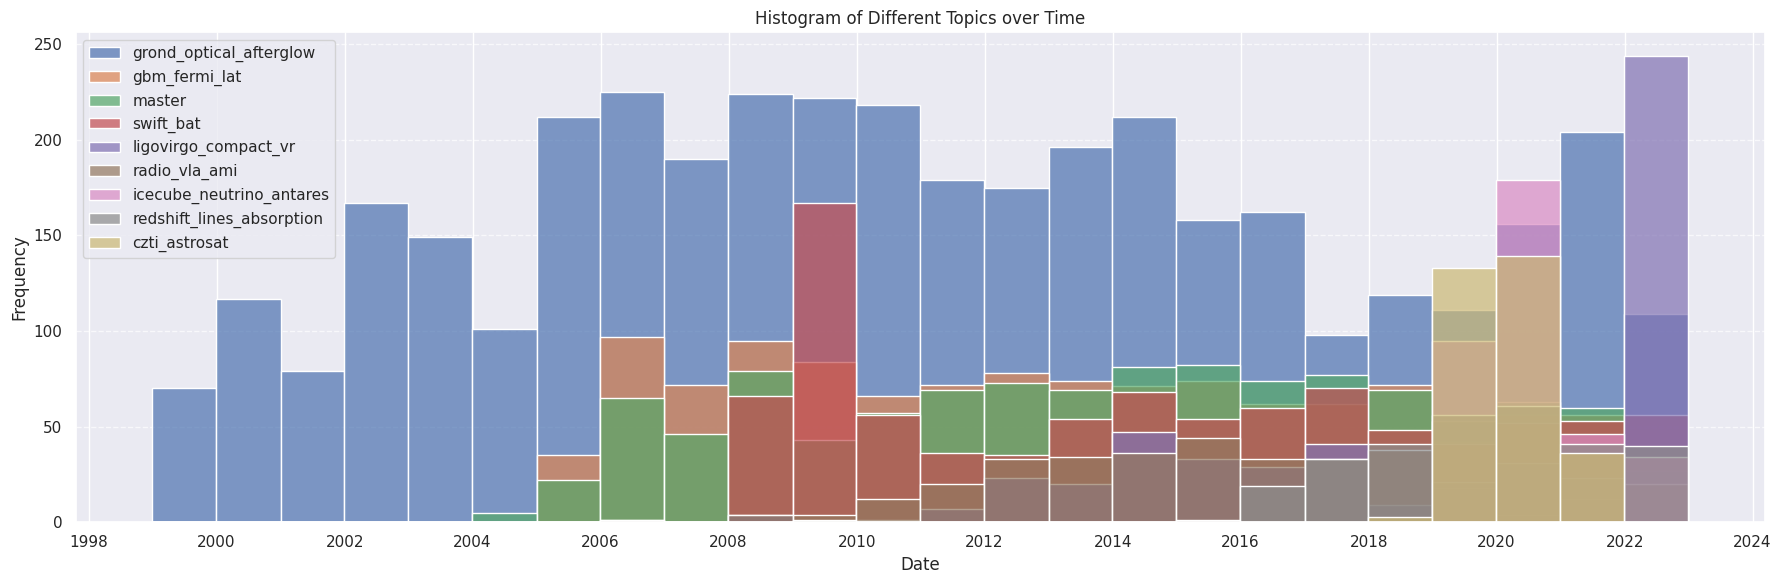

In [ ]:
'''
Perform trend analysis
'''

sns.set()
plt.figure(figsize=(18,6))

date_format = re.compile('date: *?((\d+)\/?-?(\d+)\/?-?(\d+))')
df = pd.DataFrame({'topic': topics, 'document': circulars})
all_date_series = pd.Series()
date_series_list=[]
all_topic_list = []
interesting_topic_list = [0,1,2,4,8,10,12,14,15]
interesting_topic_names = ["grond_optical_afterglow", "gbm_fermi_lat", "master", "swift_bat", "ligovirgo_compact_vr", "radio_vla_ami", "icecube_neutrino_antares", "redshift_lines_absorption", "czti_astrosat"]
count=0
for i in interesting_topic_list:
  topic = df[df.topic == i]
  docs = topic['document']
  topic_str = interesting_topic_names[count]
  count+=1
  extracted_dates = []
  extracted_years = []
  extracted_months = []
  extracted_days = []
  for i, doc in docs.items():
    matches = date_format.search(doc)
    if matches:
      date = matches.group(1)
      year = matches.group(2)
      month = matches.group(3)
      day = matches.group(4)
      extracted_dates.append(date)
      extracted_years.append(year)
      extracted_months.append(month)
      extracted_days.append(day)
  if not extracted_dates:
    continue
  years = [int(year) for year in extracted_years]
  months = [int(month) for month in extracted_months]
  days = [int(day) for day in extracted_days]

  # Convert the list of two-digit years to four-digit years
  years = [(1900 + year) if year > 24 else (2000 + year) for year in years]

  # Combine years, months, and days to create date objects
  dates = [datetime(year, month, day) for year, month, day in zip(years, months, days)]

  # Create pandas Series for the dates and normalize
  date_series = pd.Series(dates)

  date_series_list.append(date_series)
  all_date_series = all_date_series.append(date_series)
  all_topic_list.append(topic_str)

# Calculate the number of bins equal to the number of months in the date range
num_months = ((max(all_date_series).year - min(all_date_series).year))

num_years = ((max(all_date_series).year - min(all_date_series).year))

my_bins = pd.date_range(start='5/1998',end='4/2023',freq='Y')

for i, date_series in enumerate(date_series_list):
  sns.histplot(date_series, bins=mdates.date2num(my_bins), label=all_topic_list[i], alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Histogram of Different Topics over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

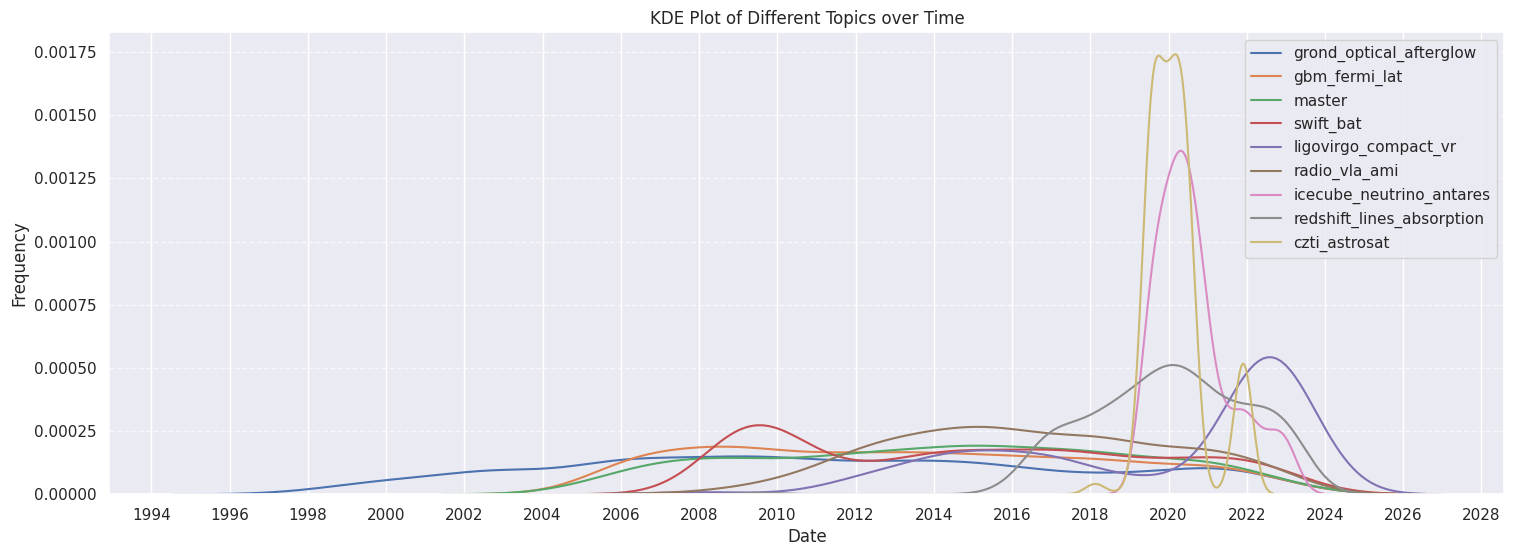

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.kdeplot(data=date_series_list[idx], label=all_topic_list[idx])
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=2))
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("KDE Plot of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

In [ ]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(circulars, topics)
topic_model.update_topics(circulars, topics=new_topics)

100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


In [ ]:
!pip install pyLDAvis
!pip install pandas==1.5.3
import pyLDAvis

# Prepare data for PyLDAVis
top_n = 100

topic_term_dists = topic_model.c_tf_idf_.toarray()[:top_n+1, ]
new_probs = probs[:, :top_n]
outlier = np.array(1 - new_probs.sum(axis=1)).reshape(-1, 1)
doc_topic_dists = np.hstack((new_probs, outlier))
doc_lengths = [len(doc) for doc in circulars]
vocab = [word for word in topic_model.vectorizer_model.vocabulary_.keys()]
term_frequency = [topic_model.vectorizer_model.vocabulary_[word] for word in vocab]

data = {'topic_term_dists': topic_term_dists,
        'doc_topic_dists': doc_topic_dists,
        'doc_lengths': doc_lengths,
        'vocab': vocab,
        'term_frequency': term_frequency}

# Visualize using pyLDAvis
vis_data= pyLDAvis.prepare(**data, mds='mmds')
pyLDAvis.display(vis_data)

In [ ]:
'''
Visualize c-TF-IDF scores
'''

topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
'''
Visualize embeddings
'''

from sentence_transformers import SentenceTransformer
from umap import UMAP

sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(circulars, show_progress_bar=True)

In [ ]:
# Run the visualization with the original embeddings
topic_model.visualize_documents(circulars, embeddings=embeddings)

# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(circulars, reduced_embeddings=reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
topic_model.visualize_documents(circulars, reduced_embeddings=reduced_embeddings)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [["redshift", "emission", "absorption", "photometric", "spectroscopic"]]

In [ ]:
'''
Build Seeded Topic Model
'''

guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 20)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   8345              -1_grb_observations_optical_afterglow   
1      0   8733               0_grb_optical_observations_afterglow   
2      1   7136                               1_bat_swift_xrt_uvot   
3      2   2409                        2_gbm_fermi_degrees_monitor   
4      3   1582  3_mastersaao_masteriac_masterkislovodsk_master...   
5      4   1487                            4_ligovirgo_gw_ligo_lvc   
6      5   1482                     5_konuswind_peak_czti_emission   
7      6    704         6_triangulation_ipn_triangulated_konuswind   
8      7    667                7_icecube_neutrino_tracklike_events   
9      8    288               8_agile_mcal_inafiaps_inafoasbologna   

                                      Representation  \
0  [grb, observations, optical, afterglow, swift,...   
1  [grb, optical, observations, afterglow, images...   
2  [bat, swift, xrt, uvot, burst, powerlaw, grb, ...   
3  [gbm, fermi, degrees, monitor, lat, gammaray, ...   
4  [mastersaao, masteriac, masterkislovodsk, mast...   
5  [ligovirgo, gw, ligo, lvc, candidates, antares...   
6  [konuswind, peak, czti, emission, burst, grb, ...   
7  [triangulation, ipn, triangulated, konuswind, ...   
8  [icecube, neutrino, tracklike, events, gammara...   
9  [agile, mcal, inafiaps, inafoasbologna, grid, ...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  15745\nsubjec...  
1  [title:   gcn circular\nnumber:  21050\nsubjec...  
2  [title:   gcn circular\nnumber:  16919\nsubjec...  
3  [title:   gcn circular\nnumber:  23562\nsubjec...  
4  [title:   gcn circular\nnumber:  24887\nsubjec...  
5  [title:   gcn circular\nnumber:  24503\nsubjec...  
6  [title:   gcn circular\nnumber:  24373\nsubjec...  
7  [title:   gcn grb observation report\nnumber: ...  
8  [title:   gcn circular\nnumber:  33548\nsubjec...  
9  [title:   gcn circular\nnumber:  30106\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 18/18 [00:00<00:00, 80.56it/s]


#Step 7: Evaluate using Coherence Score

In [ ]:
cleaned_docs = guided_topic_model._preprocess_text(circulars)

# Extract vectorizer and analyzer from BERTopic
vectorizer = guided_topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_npmi')
coherence = coherence_model.get_coherence()
print(f"The coherence score for BERTopic is: {coherence}")

0.2118771892909498


#Step 8: Rerunning Guided Topic Modelling for New Event-Based Seed

Seed 1

In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [['kilonova', 'supernova']]

In [ ]:
'''
Build Seeded Topic Model
'''

guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 20)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   8267              -1_grb_observations_optical_afterglow   
1      0   8892               0_grb_optical_observations_afterglow   
2      1   7232                               1_bat_swift_xrt_uvot   
3      2   2410                            2_gbm_fermi_degrees_lat   
4      3   2228                         3_konuswind_peak_grb_burst   
5      4   1482  4_mastersaao_masterkislovodsk_masteriac_master...   
6      5   1446                     5_ligovirgo_gw_ligo_candidates   
7      6    649                6_icecube_neutrino_tracklike_events   
8      7    219                         7_ibas_grb_attitude_alerts   
9      8    193          8_insighthxmt_insighthxmthe_csi_detectors   

                                      Representation  \
0  [grb, observations, optical, afterglow, swift,...   
1  [grb, optical, observations, afterglow, images...   
2  [bat, swift, xrt, uvot, burst, grb, powerlaw, ...   
3  [gbm, fermi, degrees, lat, monitor, gammaray, ...   
4  [konuswind, peak, grb, burst, czti, ergcm2, tr...   
5  [mastersaao, masterkislovodsk, masteriac, mast...   
6  [ligovirgo, gw, ligo, candidates, lvc, tca, ga...   
7  [icecube, neutrino, tracklike, events, gammara...   
8  [ibas, grb, attitude, alerts, errata, circular...   
9  [insighthxmt, insighthxmthe, csi, detectors, p...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  10143\nsubjec...  
1  [title:   gcn circular\nnumber:  22479\nsubjec...  
2  [title:   gcn circular\nnumber:  6210\nsubject...  
3  [title:   gcn circular\nnumber:  22485\nsubjec...  
4  [title:   gcn circular\nnumber:  21205\nsubjec...  
5  [title:   gcn circular\nnumber:  30827\nsubjec...  
6  [title:   gcn circular\nnumber:  24632\nsubjec...  
7  [title:   gcn circular\nnumber:  33048\nsubjec...  
8  [title:   gcn grb observation report\nnumber: ...  
9  [title:   gcn circular\nnumber:  22287\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 18/18 [00:00<00:00, 53.57it/s]


In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

cleaned_docs = guided_topic_model._preprocess_text(circulars)

# Extract vectorizer and analyzer from BERTopic
vectorizer = guided_topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_npmi')
coherence = coherence_model.get_coherence()
print(f"The coherence score for BERTopic is: {coherence}")

The coherence score for BERTopic is: 0.2262933916406913


Seed 2

In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [['gamma-ray', 'x-ray', 'high energy', 'fermi', 'swift', 'hawc', 'magic', 'hess', 'sgr', 'grb', 'prompt'],
                   ['optical', 'vlt', 'gemini', 'sdss', 'hst', 'jwst', 'kilonova', 'supernova', 'grb', 'afterglow'],
                   ['radio', 'vla', 'gmrt', 'frb', 'afterglow', 'grb', 'fast radio burst'],
                   ['gw', 'lvk', 'binary-merger', 'ligo', 'virgo', 'lvc', 'bbh', 'bns', 'nsbh', 'compact binary merger'],
                   ['neutrino', 'icecube', 'amon']]


In [ ]:
'''
Build Seeded Topic Model
'''

guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 20)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 18/18 [00:00<00:00, 54.35it/s]


In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

cleaned_docs = guided_topic_model._preprocess_text(circulars)

# Extract vectorizer and analyzer from BERTopic
vectorizer = guided_topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_npmi')
coherence = coherence_model.get_coherence()
print(f"The coherence score for BERTopic is: {coherence}")

Seed 3

In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [['grb, kilonova, supernova'],
                   ['sgr', 'magnetar'],
                   ['frb'],
                   ['neutrinos', 'icecube'],
                   ['gw', 'lvk', 'binary-merger', 'lvc']]

In [ ]:
'''
Build Seeded Topic Model
'''

guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 20)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   8255              -1_grb_optical_observations_afterglow   
1      0   8808               0_grb_optical_observations_afterglow   
2      1   7116                              1_bat_swift_xrt_burst   
3      2   2184                            2_gbm_fermi_degrees_lat   
4      3   1844                        3_konuswind_peak_czti_burst   
5      4   1543                            4_ligovirgo_gw_ligo_lvc   
6      5   1537  5_mastersaao_masterkislovodsk_masteriac_master...   
7      6    666                6_icecube_neutrino_tracklike_events   
8      7    659         7_triangulation_ipn_triangulated_konuswind   
9      8    222                         8_ibas_grb_attitude_alerts   

                                      Representation  \
0  [grb, optical, observations, afterglow, burst,...   
1  [grb, optical, observations, afterglow, images...   
2  [bat, swift, xrt, burst, uvot, powerlaw, grb, ...   
3  [gbm, fermi, degrees, lat, monitor, gammaray, ...   
4  [konuswind, peak, czti, burst, grb, calet, emi...   
5  [ligovirgo, gw, ligo, lvc, candidates, antares...   
6  [mastersaao, masterkislovodsk, masteriac, mast...   
7  [icecube, neutrino, tracklike, events, gammara...   
8  [triangulation, ipn, triangulated, konuswind, ...   
9  [ibas, grb, attitude, alerts, reports, circula...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  13973\nsubjec...  
1  [title:   gcn circular\nnumber:  13236\nsubjec...  
2  [title:   gcn circular\nnumber:  32431\nsubjec...  
3  [title:   gcn circular\nnumber:  22896\nsubjec...  
4  [title:   gcn circular\nnumber:  21256\nsubjec...  
5  [title:   gcn circular\nnumber:  24922\nsubjec...  
6  [title:   gcn circular\nnumber:  24710\nsubjec...  
7  [title:   gcn circular\nnumber:  33409\nsubjec...  
8  [title:   gcn grb observation report\nnumber: ...  
9  [title:   gcn grb observation report\nnumber: ...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 18/18 [00:00<00:00, 64.05it/s]


In [ ]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

cleaned_docs = guided_topic_model._preprocess_text(circulars)

# Extract vectorizer and analyzer from BERTopic
vectorizer = guided_topic_model.vectorizer_model
analyzer = vectorizer.build_analyzer()

# Extract features for Topic Coherence evaluation
words = vectorizer.get_feature_names_out()
tokens = [analyzer(doc) for doc in cleaned_docs]
dictionary = corpora.Dictionary(tokens)
corpus = [dictionary.doc2bow(token) for token in tokens]
topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

# Evaluate
coherence_model = CoherenceModel(topics=topic_words,
                                 texts=tokens,
                                 corpus=corpus,
                                 dictionary=dictionary,
                                 coherence='c_npmi')
coherence = coherence_model.get_coherence()
print(f"The coherence score for BERTopic is: {coherence}")

Testing different cluster numbers with Seed 2:

In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [['gamma-ray', 'x-ray', 'high-energy', 'very-high-energy' 'fermi', 'hawc', 'magic', 'hess', 'sgr', 'grb', 'prompt', 'kev', 'mev', 'gev', 'tev', 'konus-wind', 'astrosat', 'polar', 'integral', 'calet', 'swift/xrt', 'swift/bat', 'fermi gbm', 'fermi-lat', 'maxi' 'agile', 'agile/mcal', 'swift-bat'],
                   ['optical', 'vlt', 'gemini', 'hst', 'jwst', 'kilonova', 'supernova', 'afterglow', 'magnitude', 'mag', 'gtc', 'grb', 'ztf', 'mondy', 'goto', 'sao-ras', 'spectroscopy', 'photometry', 'redshift', 'absorption', 'emission', 'zwicky transient facility', 'camera', 'g-band', 'r-band', 'kait', 'swift/uvot', 'nordic optical telescope', 'host galaxy', 'sdss', 'x-shooter', 'spectrograph', 'wavelength', 'grandma', 'filter'],
                   ['radio', 'vla', 'gmrt', 'frb', 'afterglow', 'fast radio burst', 'ujy', 'ami-la', 'ata', 'noema', 'emerlin', 'askap', 'grb', 'meerkat', 'alma', 'tca', 'vlba', 'vlbi', 'jansky', 'ghz', 'nrao', 'very long baseline interferometry'],
                   ['gw', 'lvk', 'binary-merger', 'ligo', 'virgo', 'lvc', 'bbh', 'bns', 'nsbh', 'compact binary merger'],
                   ['neutrino', 'icecube', 'amon']]

In [ ]:
# embedding_model = pipeline("feature-extraction", model="adsabs/astroBERT")
# guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 10, calculate_probabilities=True, embedding_model=embedding_model)
# guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 90c1371d-a0a0-42f7-b1a2-12c4218bdcd3)')' thrown while requesting HEAD https://huggingface.co/adsabs/astroBERT/resolve/main/special_tokens_map.json
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


RuntimeError: ignored

In [ ]:
'''
Build Seeded Topic Model and get Coherence Scores for different topic numbers
'''

import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

coherence_score_list = []

for i in range(10, 21, 2):
  guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = i)
  guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

  cleaned_docs = guided_topic_model._preprocess_text(circulars)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = guided_topic_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

  # Evaluate
  coherence_model = CoherenceModel(topics=topic_words,
                                  texts=tokens,
                                  corpus=corpus,
                                  dictionary=dictionary,
                                  coherence='c_npmi')
  coherence = coherence_model.get_coherence()
  coherence_score_list.append((i, coherence))
  print(f"The coherence score for BERTopic with {i} topic clusters is: {coherence}")

KeyboardInterrupt: ignored

In [ ]:
'''
Plot coherence scores vs. topic numbers
'''

sns.set()
coherence_df = pd.DataFrame(coherence_score_list, columns=['Number of Topics', 'Coherence Score'])
sns.stripplot(data=coherence_df, x='Number of Topics', y='Coherence Score')

We see that the best coherence score is found for number of clusters = 10

In [ ]:
guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 10)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   8242                  -1_grb_observations_optical_burst   
1      0  13787                            0_grb_gbm_fermi_optical   
2      1   7418                              1_bat_swift_xrt_burst   
3      2   1568  2_mastersaao_masterkislovodsk_masteriac_master...   
4      3   1479                     3_ligovirgo_gw_ligo_candidates   
5      4    805                4_icecube_neutrino_events_tracklike   
6      5    237               5_agile_mcal_inafiaps_inafoasbologna   
7      6     69                   6_operatorss_replyto_mail_faster   
8      7     36                     7_plates_golosiiv_review_dbgpa   
9      8     12              8_notify_content_addressee_addressees   

                                      Representation  \
0  [grb, observations, optical, burst, afterglow,...   
1  [grb, gbm, fermi, optical, burst, observations...   
2  [bat, swift, xrt, burst, uvot, grb, powerlaw, ...   
3  [mastersaao, masterkislovodsk, masteriac, mast...   
4  [ligovirgo, gw, ligo, candidates, lvc, observa...   
5  [icecube, neutrino, events, tracklike, gammara...   
6  [agile, mcal, inafiaps, inafoasbologna, 04100,...   
7  [operatorss, replyto, mail, faster, controlms,...   
8  [plates, golosiiv, review, dbgpa, ukrainian, n...   
9  [notify, content, addressee, addressees, alter...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  23277\nsubjec...  
1  [title:   gcn circular\nnumber:  9849\nsubject...  
2  [title:   gcn circular\nnumber:  5743\nsubject...  
3  [title:   gcn circular\nnumber:  29779\nsubjec...  
4  [title:   gcn circular\nnumber:  24522\nsubjec...  
5  [title:   gcn circular\nnumber:  28715\nsubjec...  
6  [title:   gcn circular\nnumber:  30106\nsubjec...  
7  [the recent circular from t.cline was the resu...  
8  [title:   gcn circular\nnumber:  13174\nsubjec...  
9  [title:   gcn circular\nnumber:  18646\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 8/8 [00:00<00:00, 29.08it/s]


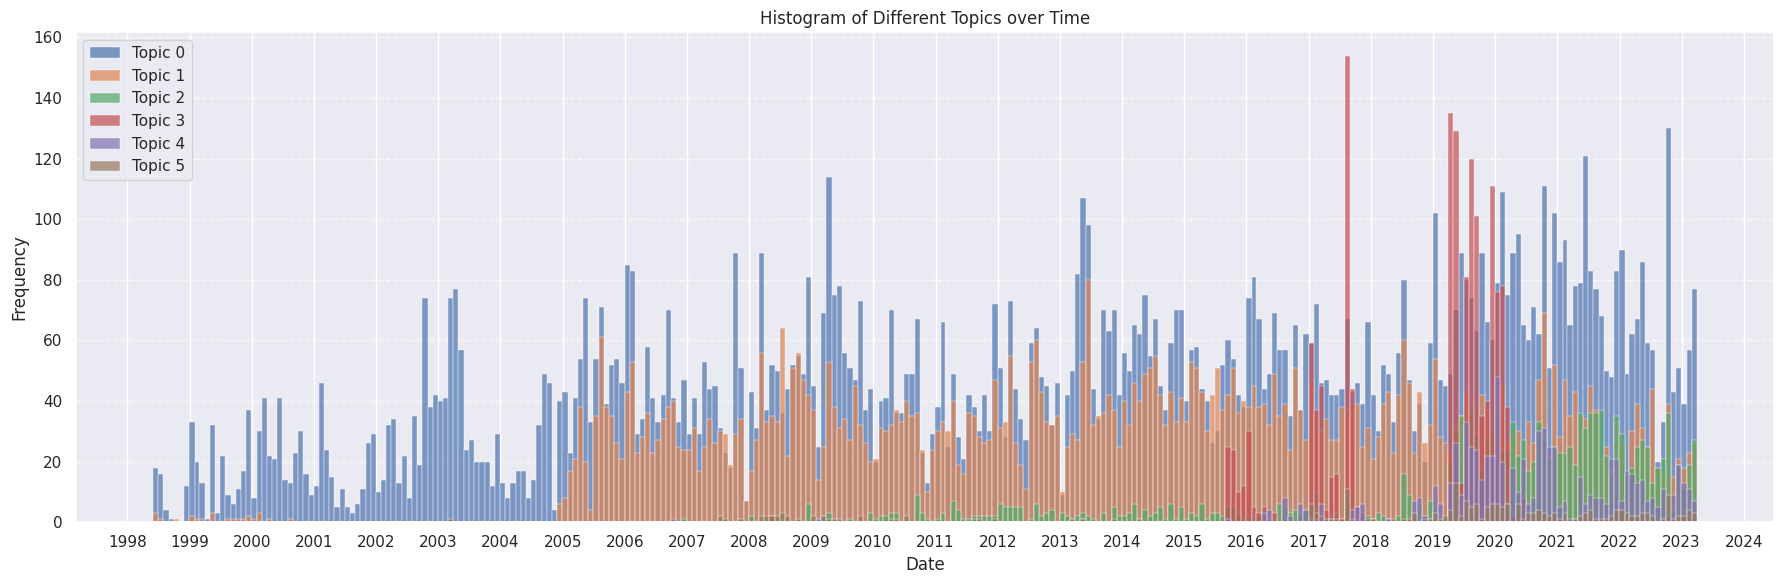

In [ ]:
'''
Perform trend analysis
'''

sns.set()
plt.figure(figsize=(18,6))

date_format = re.compile('date: *?((\d+)\/?-?(\d+)\/?-?(\d+))')
df = pd.DataFrame({'topic': guided_topics, 'document': circulars})
all_date_series = pd.Series()
date_series_list=[]
all_topic_list = []
interesting_topic_list = [0,1,2,3,4,5]

for i in interesting_topic_list:
  topic = df[df.topic == i]
  topic_str = "Topic " + str(i)
  docs = topic['document']
  extracted_dates = []
  extracted_years = []
  extracted_months = []
  extracted_days = []
  for i, doc in docs.items():
    matches = date_format.search(doc)
    if matches:
      date = matches.group(1)
      year = matches.group(2)
      month = matches.group(3)
      day = matches.group(4)
      extracted_dates.append(date)
      extracted_years.append(year)
      extracted_months.append(month)
      extracted_days.append(day)
  if not extracted_dates:
    continue
  years = [int(year) for year in extracted_years]
  months = [int(month) for month in extracted_months]
  days = [int(day) for day in extracted_days]

  # Convert the list of two-digit years to four-digit years
  years = [(1900 + year) if year > 24 else (2000 + year) for year in years]

  # Combine years, months, and days to create date objects
  dates = [datetime(year, month, day) for year, month, day in zip(years, months, days)]

  # Create pandas Series for the dates and normalize
  date_series = pd.Series(dates)

  date_series_list.append(date_series)
  all_date_series = all_date_series.append(date_series)
  all_topic_list.append(topic_str)

# Calculate the number of bins equal to the number of months in the date range
num_months = ((max(all_date_series).year - min(all_date_series).year) * 12 +
            max(all_date_series).month - min(all_date_series).month + 1)

num_years = ((max(all_date_series).year - min(all_date_series).year))

my_bins = pd.date_range(start='5/1998',end='4/2023',freq='M')

for i, date_series in enumerate(date_series_list):
  sns.histplot(date_series, bins=mdates.date2num(my_bins), label=all_topic_list[i], alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Histogram of Different Topics over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

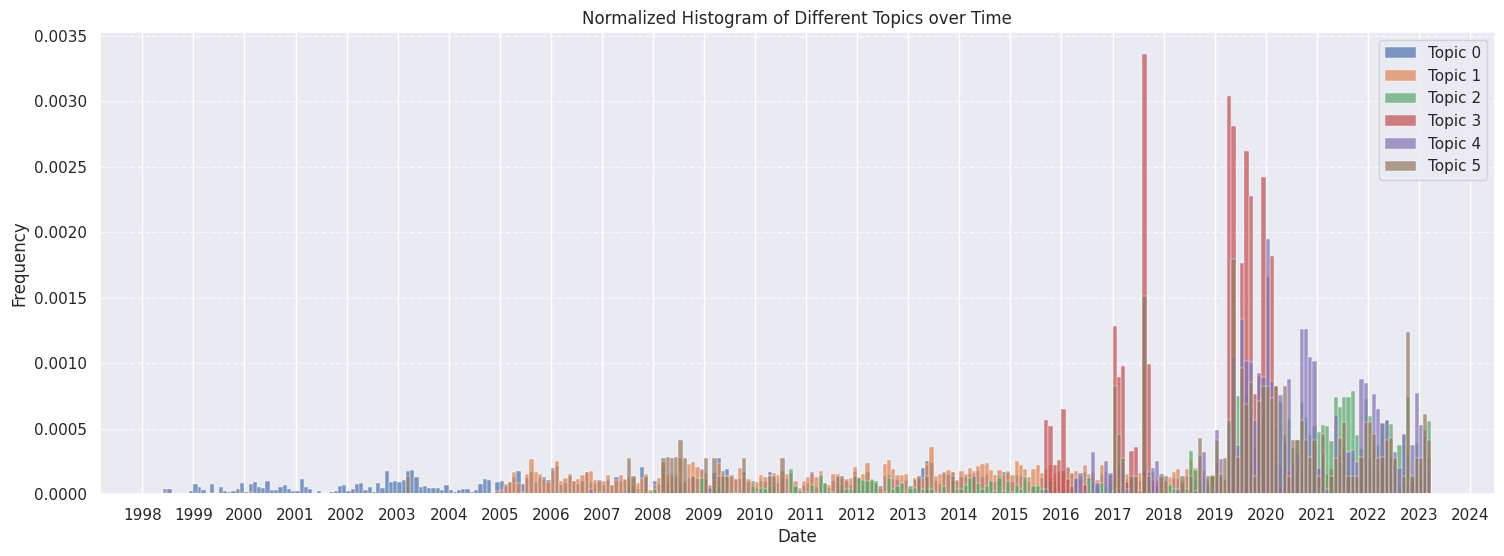

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.histplot(data=date_series_list[idx], bins=mdates.date2num(my_bins), label=all_topic_list[idx], alpha=0.7, stat="density")
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("Normalized Histogram of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

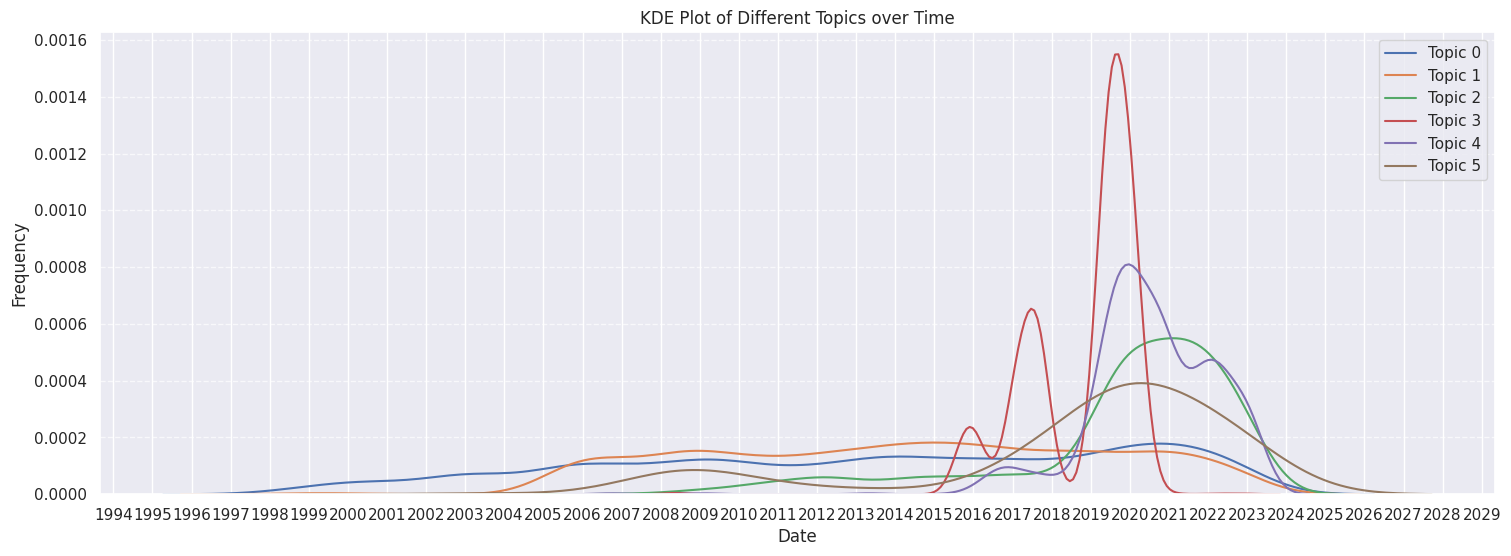

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.kdeplot(data=date_series_list[idx], label=all_topic_list[idx])
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("KDE Plot of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

In [ ]:
print(f"Date range is from: 0{min(all_date_series).month}\\{min(all_date_series).year} to 0{max(all_date_series).month}\\{max(all_date_series).year}")

Date range is from: 05\1998 to 04\2023


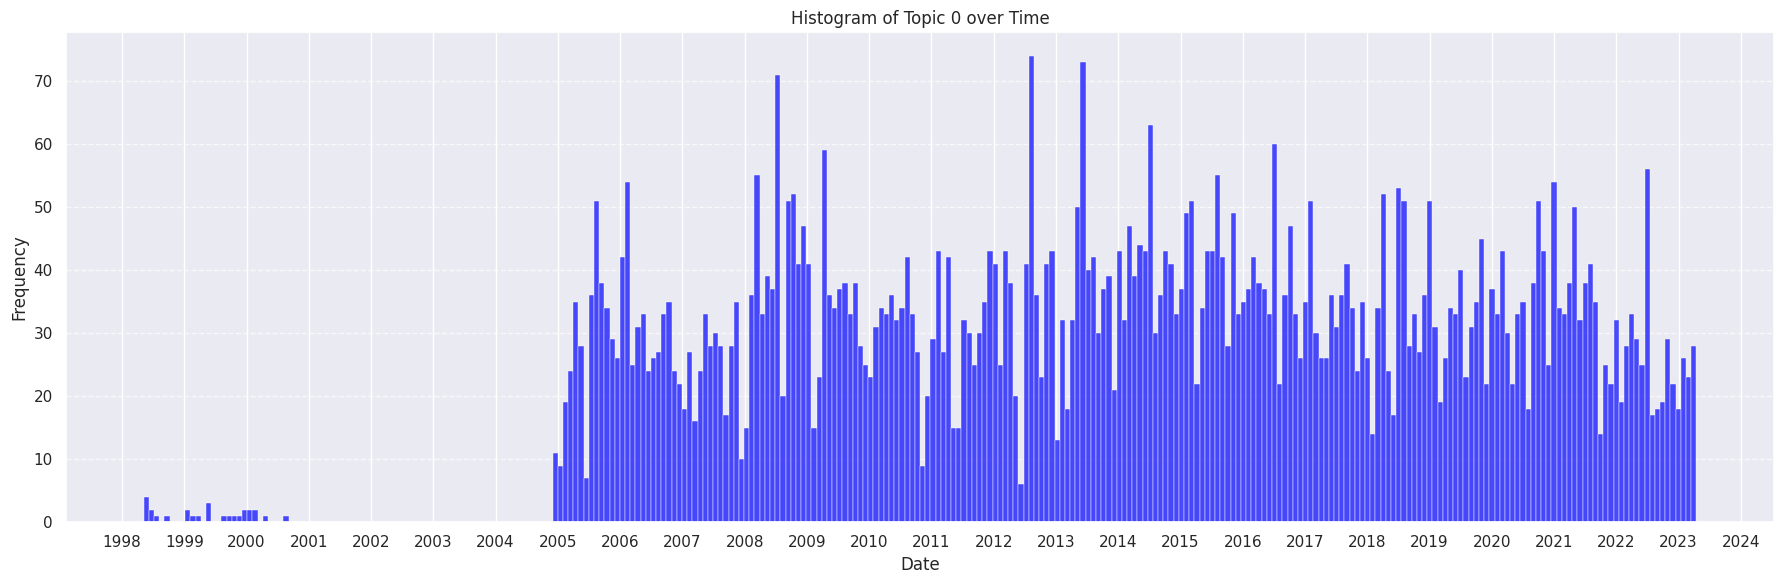

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[0], bins=num_months, color="blue", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 0 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

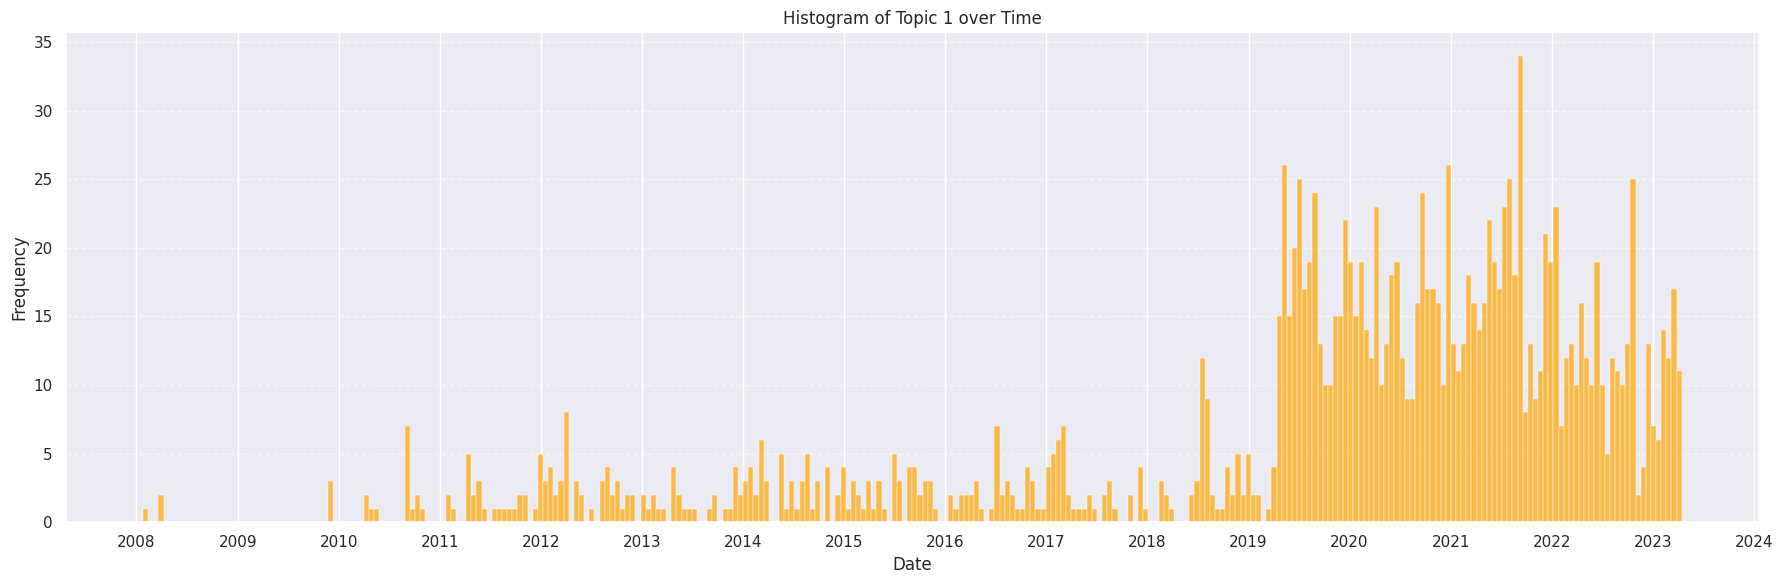

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[1], bins=num_months, color="orange", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 1 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

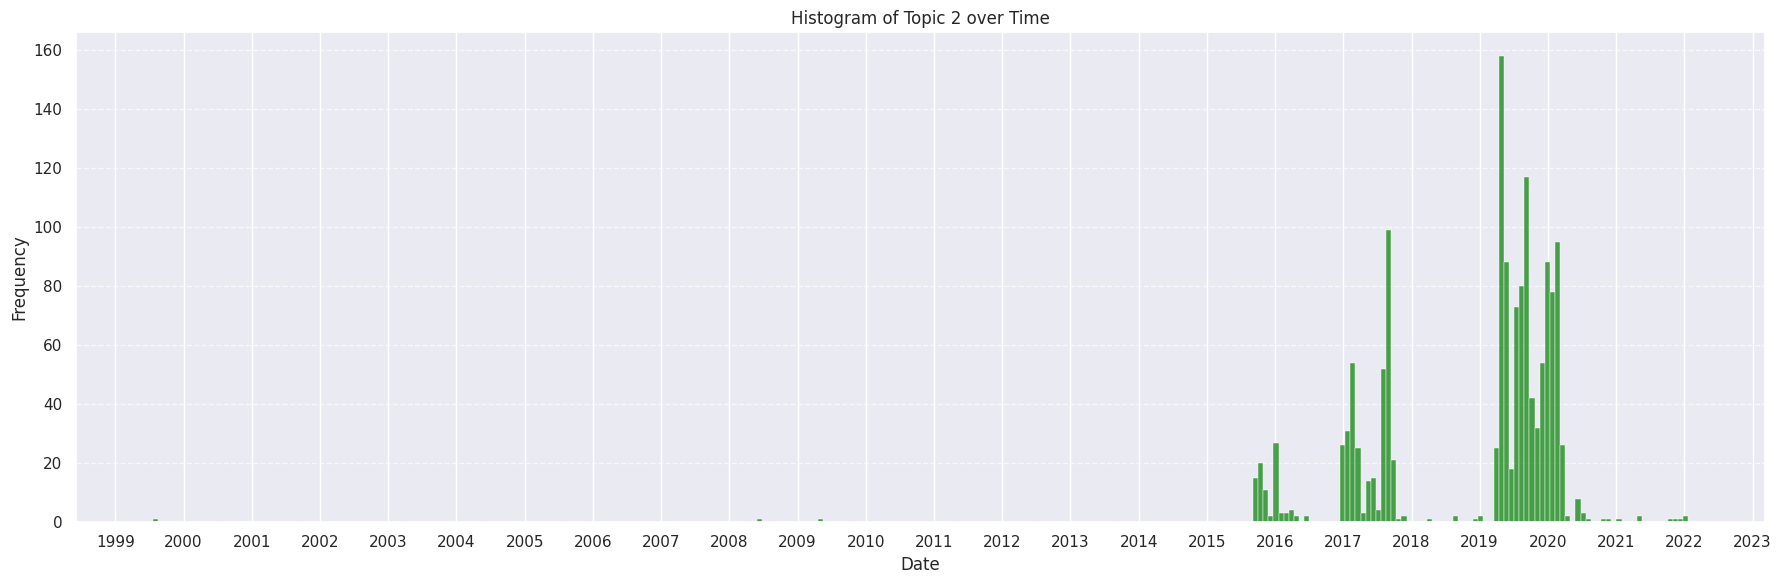

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[2], bins=num_months, color="green", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 2 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

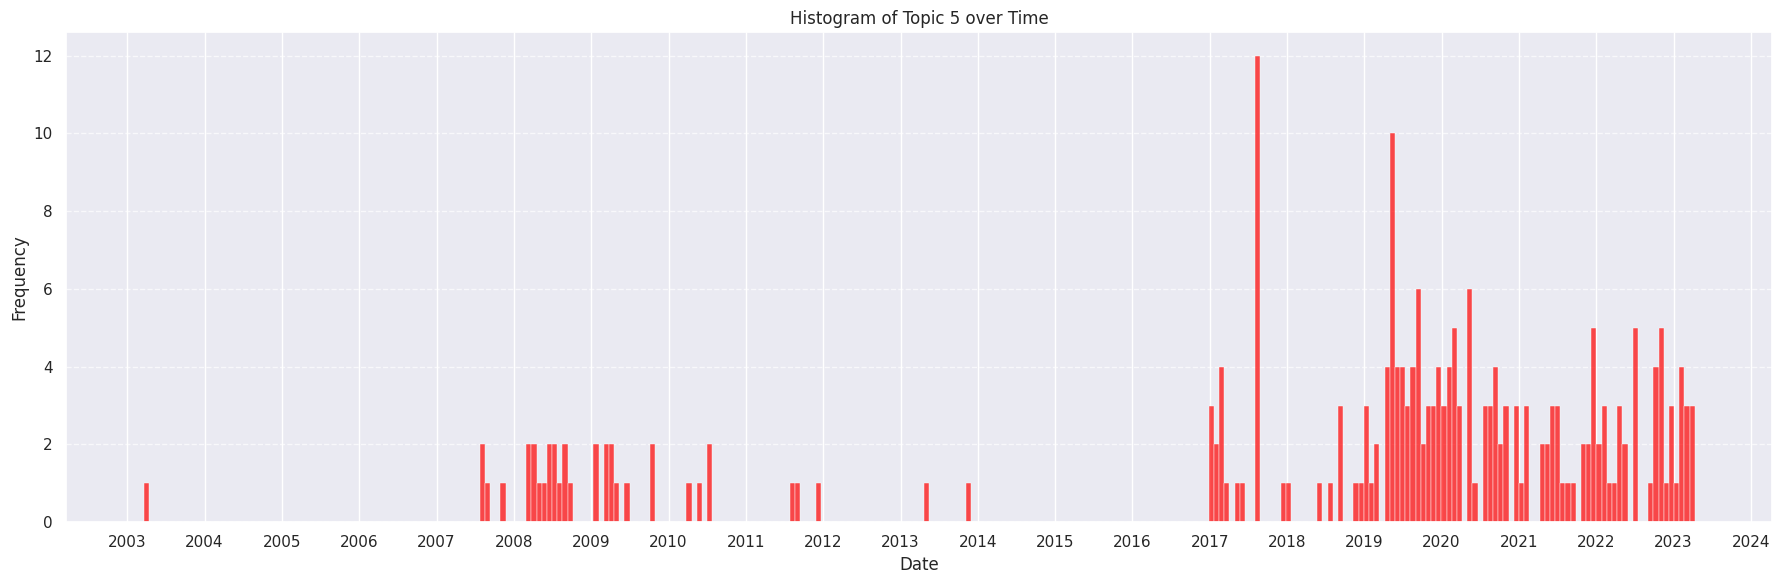

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[3], bins=num_months, color="red", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 5 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

Testing different cluster numbers with Seed 3:

In [ ]:
'''
Create topic seeds for guided topic modelling approach
'''

seed_topic_list = [['kilonova', 'supernova', 'jwst', 'hst', 'grandma', 'grandma/kilonova-catcher', 'ztf', 'nirspec spectroscopy', 'filters', 'optical', 'infrared', 'chandra'],
                   ['sgr', 'magnetar'],
                   ['frb'],
                   ['neutrinos', 'icecube'],
                   ['gw', 'lvk', 'binary-merger', 'lvc']]

In [ ]:
'''
Build Seeded Topic Model and get Coherence Scores for different topic numbers
'''
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

coherence_score_list = []

for i in range(10, 21):
  guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = i)
  guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

  cleaned_docs = guided_topic_model._preprocess_text(circulars)

  # Extract vectorizer and analyzer from BERTopic
  vectorizer = guided_topic_model.vectorizer_model
  analyzer = vectorizer.build_analyzer()

  # Extract features for Topic Coherence evaluation
  words = vectorizer.get_feature_names_out()
  tokens = [analyzer(doc) for doc in cleaned_docs]
  dictionary = corpora.Dictionary(tokens)
  corpus = [dictionary.doc2bow(token) for token in tokens]
  topic_words = [[words for words, _ in guided_topic_model.get_topic(topic)] for topic in range(len(set(guided_topics))-1)]

  # Evaluate
  coherence_model = CoherenceModel(topics=topic_words,
                                  texts=tokens,
                                  corpus=corpus,
                                  dictionary=dictionary,
                                  coherence='c_npmi')
  coherence = coherence_model.get_coherence()
  coherence_score_list.append((i, coherence))
  print(f"The coherence score for BERTopic with {i} topic clusters is: {coherence}")

The coherence score for BERTopic with 10 topic clusters is: 0.2145545614263495
The coherence score for BERTopic with 11 topic clusters is: 0.18626372490127588
The coherence score for BERTopic with 12 topic clusters is: 0.18385683590439908
The coherence score for BERTopic with 13 topic clusters is: 0.17519658824943662
The coherence score for BERTopic with 14 topic clusters is: 0.19239719032057526
The coherence score for BERTopic with 15 topic clusters is: 0.2082904339636961
The coherence score for BERTopic with 16 topic clusters is: 0.1875533190133066
The coherence score for BERTopic with 17 topic clusters is: 0.19655041237647777
The coherence score for BERTopic with 18 topic clusters is: 0.21234199948392088
The coherence score for BERTopic with 19 topic clusters is: 0.1774159971725944
The coherence score for BERTopic with 20 topic clusters is: 0.1961803383015301


<Axes: xlabel='Number of Topics', ylabel='Coherence Score'>

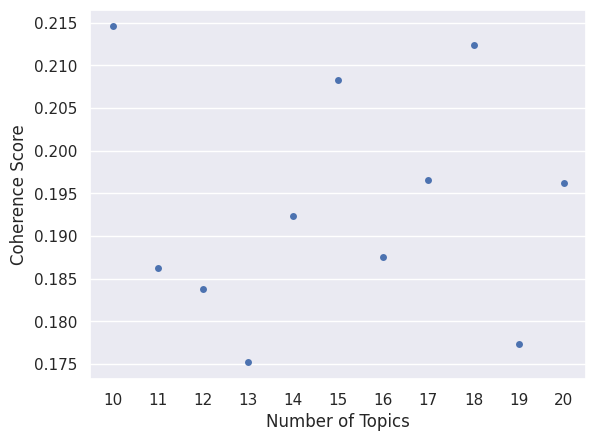

In [ ]:
'''
Plot coherence scores vs. topic numbers
'''

sns.set()
coherence_df = pd.DataFrame(coherence_score_list, columns=['Number of Topics', 'Coherence Score'])
sns.stripplot(data=coherence_df, x='Number of Topics', y='Coherence Score')

We see that the best coherence score is found for number of clusters = 10

In [ ]:
guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 10)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   8009                  -1_grb_observations_optical_burst   
1      0  14294                              0_grb_gbm_fermi_burst   
2      1   7164                              1_bat_swift_xrt_burst   
3      2   1564                     2_ligovirgo_gw_candidates_ligo   
4      3   1548  3_mastersaao_masterkislovodsk_masteriac_master...   
5      4    670                4_icecube_neutrino_events_tracklike   
6      5    287               5_agile_mcal_inafiaps_inafoasbologna   
7      6     68                   6_operatorss_replyto_mail_faster   
8      7     36                     7_plates_golosiiv_review_dbgpa   
9      8     13              8_notify_content_addressee_addressees   

                                      Representation  \
0  [grb, observations, optical, burst, afterglow,...   
1  [grb, gbm, fermi, burst, optical, observations...   
2  [bat, swift, xrt, burst, uvot, grb, powerlaw, ...   
3  [ligovirgo, gw, candidates, ligo, lvc, antares...   
4  [mastersaao, masterkislovodsk, masteriac, mast...   
5  [icecube, neutrino, events, tracklike, gammara...   
6  [agile, mcal, inafiaps, inafoasbologna, grid, ...   
7  [operatorss, replyto, mail, faster, controlms,...   
8  [plates, golosiiv, review, dbgpa, ukrainian, n...   
9  [notify, content, addressee, addressees, alter...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  5762\nsubject...  
1  [title:   gcn circular\nnumber:  9428\nsubject...  
2  [title:   gcn circular\nnumber:  33005\nsubjec...  
3  [title:   gcn circular\nnumber:  25610\nsubjec...  
4  [title:   gcn circular\nnumber:  29917\nsubjec...  
5  [title:   gcn circular\nnumber:  33548\nsubjec...  
6  [title:   gcn circular\nnumber:  31733\nsubjec...  
7  [the recent circular from t.cline was the resu...  
8  [title:   gcn circular\nnumber:  13174\nsubjec...  
9  [title:   gcn circular\nnumber:  18646\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = guided_topic_model.hierarchical_topics(circulars)
guided_topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

100%|██████████| 8/8 [00:00<00:00, 58.93it/s]


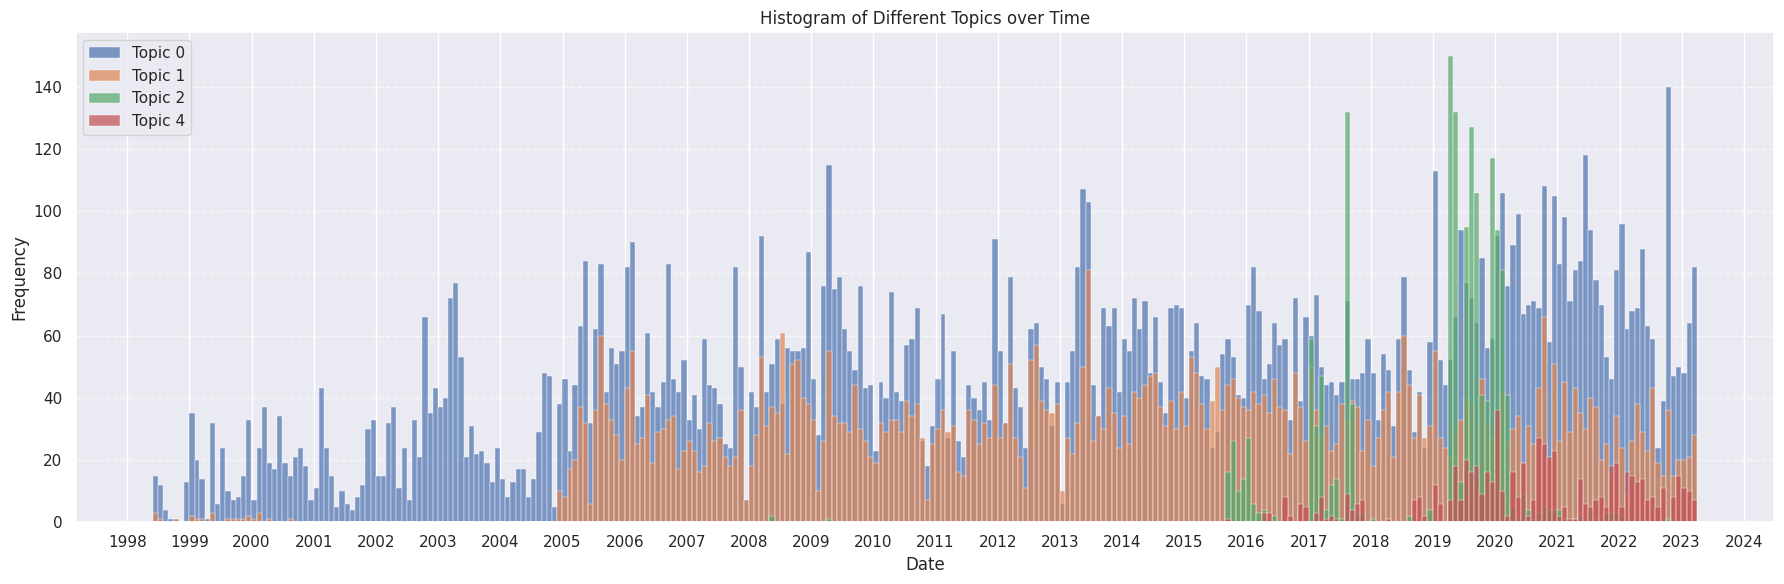

In [ ]:
'''
Perform trend analysis
'''
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates

sns.set()
plt.figure(figsize=(18,6))

date_format = re.compile('date: *?((\d+)\/?-?(\d+)\/?-?(\d+))')
df = pd.DataFrame({'topic': guided_topics, 'document': circulars})
all_date_series = pd.Series()
date_series_list=[]
all_topic_list = []
interesting_topic_list = [0,1,2,4]

for i in interesting_topic_list:
  topic = df[df.topic == i]
  topic_str = "Topic " + str(i)
  docs = topic['document']
  extracted_dates = []
  extracted_years = []
  extracted_months = []
  extracted_days = []
  for i, doc in docs.items():
    matches = date_format.search(doc)
    if matches:
      date = matches.group(1)
      year = matches.group(2)
      month = matches.group(3)
      day = matches.group(4)
      extracted_dates.append(date)
      extracted_years.append(year)
      extracted_months.append(month)
      extracted_days.append(day)
  if not extracted_dates:
    continue
  years = [int(year) for year in extracted_years]
  months = [int(month) for month in extracted_months]
  days = [int(day) for day in extracted_days]

  # Convert the list of two-digit years to four-digit years
  years = [(1900 + year) if year > 24 else (2000 + year) for year in years]

  # Combine years, months, and days to create date objects
  dates = [datetime(year, month, day) for year, month, day in zip(years, months, days)]

  # Create pandas Series for the dates and normalize
  date_series = pd.Series(dates)

  date_series_list.append(date_series)
  all_date_series = all_date_series.append(date_series)
  all_topic_list.append(topic_str)

# Calculate the number of bins equal to the number of months in the date range
num_months = ((max(all_date_series).year - min(all_date_series).year) * 12 +
            max(all_date_series).month - min(all_date_series).month + 1)

num_years = ((max(all_date_series).year - min(all_date_series).year))

my_bins = pd.date_range(start='5/1998',end='4/2023',freq='M')

for i, date_series in enumerate(date_series_list):
  sns.histplot(date_series, bins=mdates.date2num(my_bins), label=all_topic_list[i], alpha=0.7)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title("Histogram of Different Topics over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

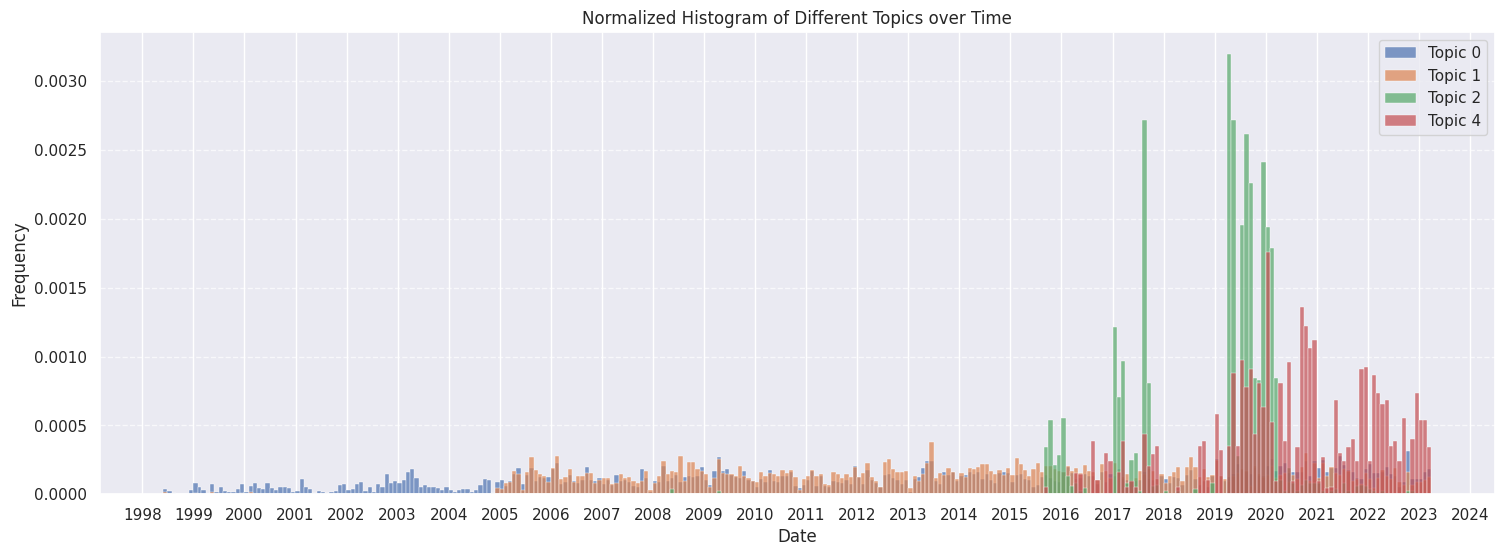

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.histplot(data=date_series_list[idx], bins=mdates.date2num(my_bins), label=all_topic_list[idx], alpha=0.7, stat="density")
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("Normalized Histogram of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

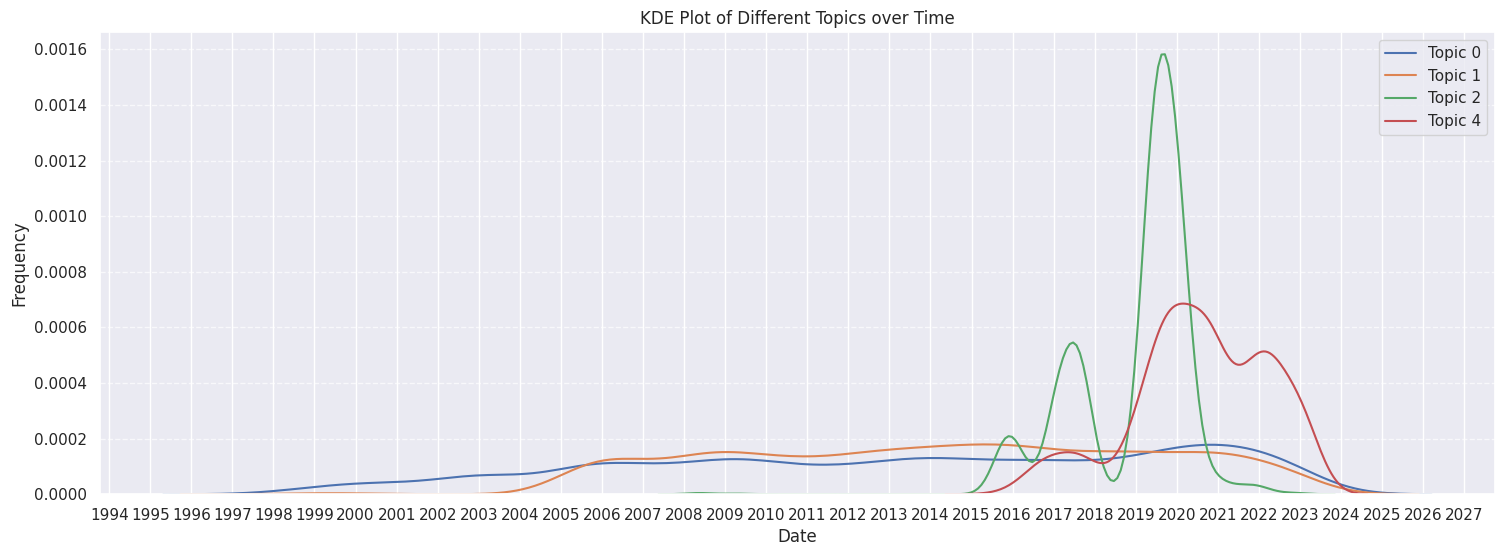

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
idx=0
for i in interesting_topic_list:
  sns.kdeplot(data=date_series_list[idx], label=all_topic_list[idx])
  idx+=1

  plt.gca().xaxis.set_major_locator(mdates.YearLocator())
  plt.xlabel("Date")
  plt.ylabel("Frequency")
  plt.title("KDE Plot of Different Topics over Time")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.legend()

In [ ]:
print(f"Date range is from: 0{min(all_date_series).month}\\{min(all_date_series).year} to 0{max(all_date_series).month}\\{max(all_date_series).year}")

Date range is from: 03\1998 to 04\2023


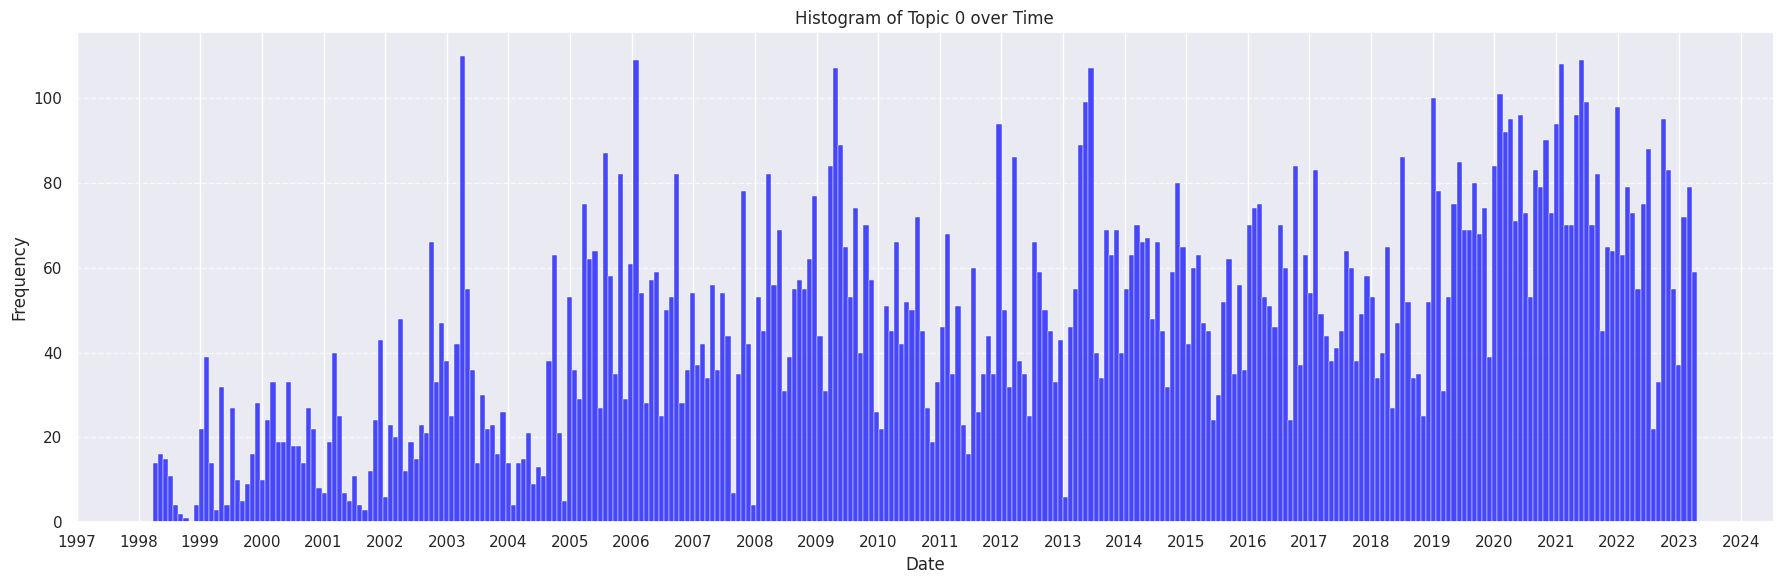

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[0], bins=num_months, color="blue", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 0 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

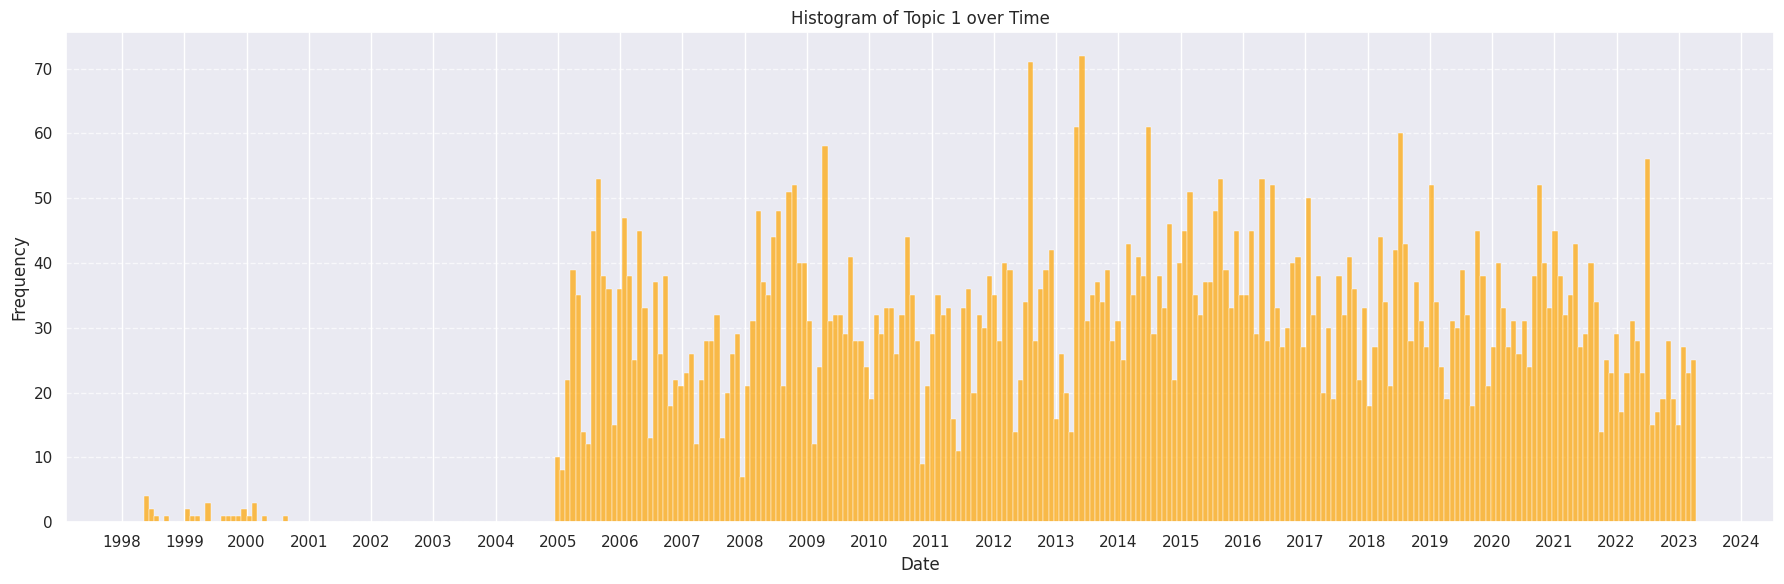

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[1], bins=num_months, color="orange", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 1 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

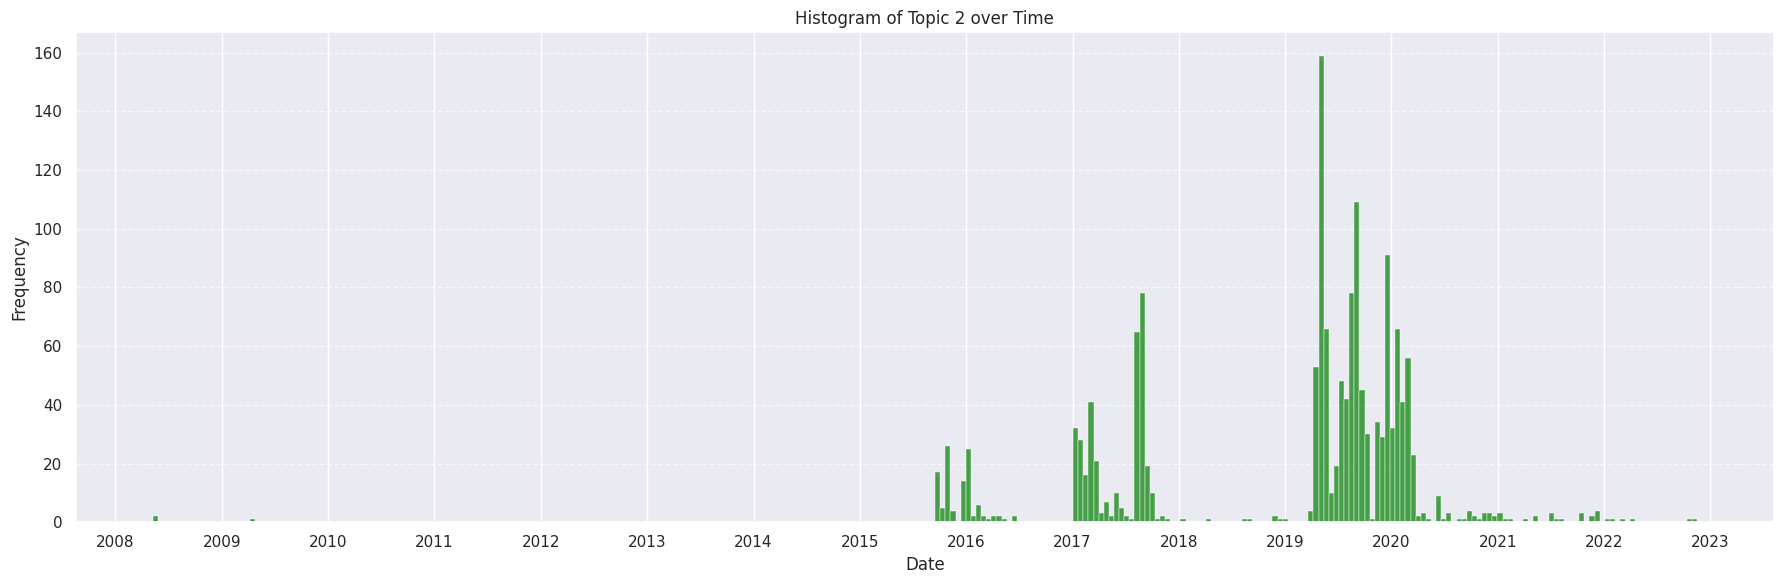

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[2], bins=num_months, color="green", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 2 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

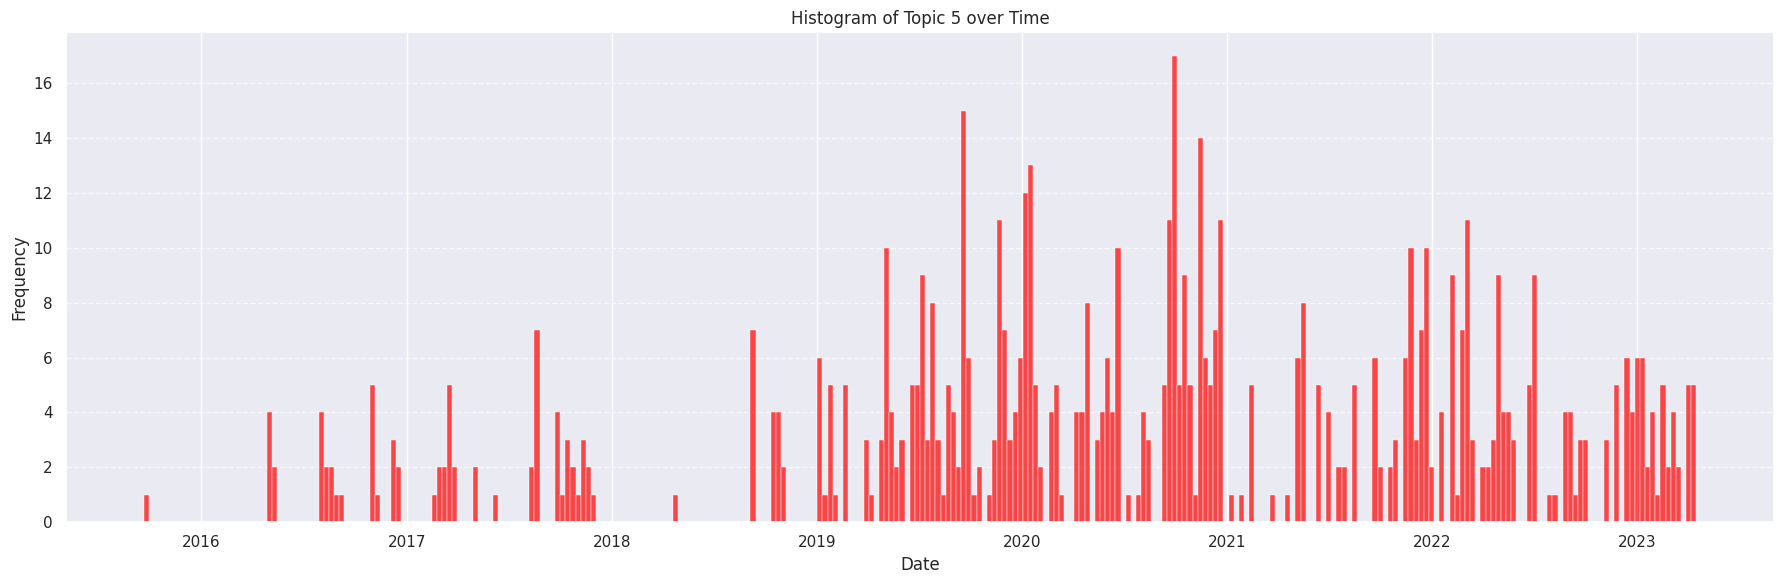

In [ ]:
sns.set()
plt.figure(figsize=(18,6))
sns.histplot(date_series_list[3], bins=num_months, color="red", alpha=0.7)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.xlabel("Date")
plt.ylabel("Frequency")
plt.title(f"Histogram of Topic 4 over Time")
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

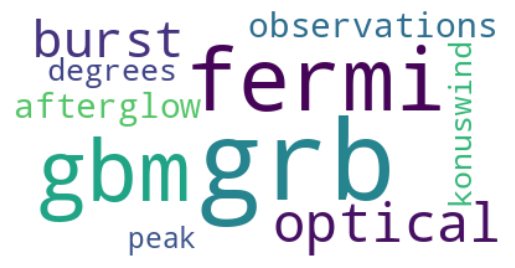

In [ ]:
'''
Generate Word Clouds for Interesting Topics
'''

!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(guided_topic_model, topic=0)

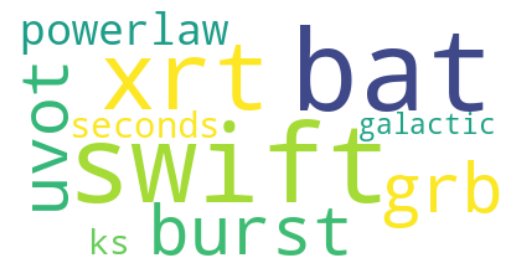

In [ ]:
create_wordcloud(guided_topic_model, topic=1)

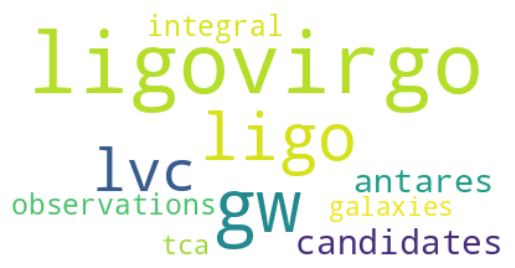

In [ ]:
create_wordcloud(guided_topic_model, topic=3)

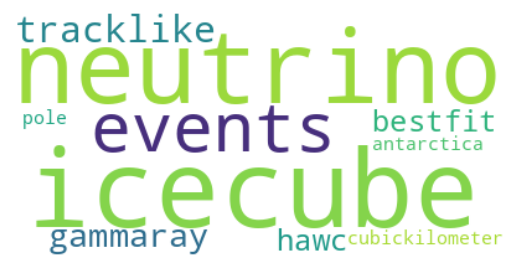

In [ ]:
create_wordcloud(guided_topic_model, topic=4)

Fine-tuning the model for better cluster representations with seed 3

In [ ]:
'''
Using more advanced LM embeddings
'''

guided_topic_model = BERTopic(embedding_model="all-mpnet-base-v2", seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = 10, calculate_probabilities=True)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                   Name  \
0     -1   6619         -1_grb_swift_optical_afterglow   
1      0  23707               0_grb_swift_master_burst   
2      1   1813                    1_ligo_virgo_gw_lvc   
3      2    856      2_icecube_neutrino_events_antares   
4      3    213               3_ibas_grb_content_rui9r   
5      4    168         4_insight_csi_detectors_counts   
6      5    162               5_swift_bat_lock_tracker   
7      6     67                6_mail_faster_fix_cline   
8      7     36     7_plates_golosiiv_review_ukrainian   
9      8     12  8_notify_addressee_addressees_altered   

                                      Representation  \
0  [grb, swift, optical, afterglow, bat, observat...   
1  [grb, swift, master, burst, xrt, fermi, bat, o...   
2  [ligo, virgo, gw, lvc, candidates, master, fra...   
3  [icecube, neutrino, events, antares, track, mu...   
4  [ibas, grb, content, rui9r, mbhem7kswg5a6l5l2t...   
5  [insight, csi, detectors, counts, url_lc, cnsa...   
6  [swift, bat, lock, tracker, grb, shower, trigg...   
7  [mail, faster, fix, cline, ago, control, probl...   
8  [plates, golosiiv, review, ukrainian, dbgpa, u...   
9  [notify, addressee, addressees, altered, copyi...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  8973\nsubject...  
1  [title:   gcn circular\nnumber:  23525\nsubjec...  
2  [title:   gcn circular\nnumber:  25861\nsubjec...  
3  [title:   gcn circular\nnumber:  28631\nsubjec...  
4  [title:   gcn grb observation report\nnumber: ...  
5  [title:   gcn circular\nnumber:  25576\nsubjec...  
6  [title:   gcn grb observation report\nnumber: ...  
7  [[gcn ops note (11oct04):  this circular (#279...  
8  [title:   gcn circular\nnumber:  11596\nsubjec...  
9  [title:   gcn circular\nnumber:  11263\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()

In [ ]:
from hdbscan import HDBSCAN

hdbscan_model = HDBSCAN(min_cluster_size=30)
guided_topic_model = BERTopic(seed_topic_list=seed_topic_list, vectorizer_model=vectorizer_model, nr_topics = "auto", hdbscan_model=hdbscan_model)
guided_topics, guided_probs = guided_topic_model.fit_transform(circulars)

In [ ]:
'''
Get top ten topics
'''

freq = guided_topic_model.get_topic_info()
freq.head(10)

Topic  Count                                               Name  \
0     -1   7461                     -1_afterglow_optical_grb_swift   
1      0   3582               0_grond_optical_afterglow_photometry   
2      1   1688             1_timeaveraged_phcm2sec_sysstat_coding   
3      2   1414                     2_swift_bat_seconds_arcseconds   
4      3   1171                    3_tstops_tstarts_uvot_exposures   
5      4    963                           4_gbm_fermi_phscm2_epeak   
6      5    898                   5_unabsorbed_bestfitting_0310_ks   
7      6    882                6_ligovirgo_lvc_galaxies_candidates   
8      7    861  7_httpwwwswiftacukxrtpositions_xrtuvot_alignme...   
9      8    856  8_masteriac_mastersaao_mastertavrida_masterkis...   

                                      Representation  \
0  [afterglow, optical, grb, swift, observations,...   
1  [grond, optical, afterglow, photometry, stars,...   
2  [timeaveraged, phcm2sec, sysstat, coding, grou...   
3  [swift, bat, seconds, arcseconds, burst, cover...   
4  [tstops, tstarts, uvot, exposures, reddening, ...   
5  [gbm, fermi, phscm2, epeak, degrees, results, ...   
6  [unabsorbed, bestfitting, 0310, ks, powerlaw, ...   
7  [ligovirgo, lvc, galaxies, candidates, vr, fer...   
8  [httpwwwswiftacukxrtpositions, xrtuvot, alignm...   
9  [masteriac, mastersaao, mastertavrida, masterk...   

                                 Representative_Docs  
0  [title:   gcn circular\nnumber:  12506\nsubjec...  
1  [title:   gcn circular\nnumber:  15177\nsubjec...  
2  [title:   gcn circular\nnumber:  15664\nsubjec...  
3  [title:   gcn grb observation report\nnumber: ...  
4  [title:   gcn circular\nnumber:  14041\nsubjec...  
5  [title:   gcn circular\nnumber:  16321\nsubjec...  
6  [title:   gcn circular\nnumber:  10719\nsubjec...  
7  [title:   gcn circular\nnumber:  25336\nsubjec...  
8  [title:   gcn circular\nnumber:  14430\nsubjec...  
9  [title:   gcn circular\nnumber:  30055\nsubjec...

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

guided_topic_model.visualize_topics()